# Entrega No. 1
## Sergio Contreras Vélez
### Ciencia de Datos 1 - Comisión 74235


El dataset elegido es una mezcla de datos del Centro Nacional de Memoria Histórica de Colombia, el cual trata sobre diferentes registros de victimización en el conflicto armado en el país. Los temas seleccionados son masacres, acciones bélicas y asesinatos selectivos. Los registros son publicados anualmente y consolidados en la página del CNMH.

El objetivo de este proyecto es analizar tendencias de los datos que sean relevantes para el diseño de política pública en el país en materia de diálogos entre actores armados.

Las hipótesis inicialmente son:

1. Concentración territorial: "El 60% de los eventos violentos se concentra en el 20% de los municipios, correlacionados con zonas de economías ilegales (minería, narcotráfico)."
2. Acuerdos de paz: "Los homicidios a líderes sociales aumentaron en el primer año post-acuerdo (2017 vs 2016)."
3. Capturas preventivas: "Los municipios con operativos de captura (CAPTURADOS >0) reducen un 20% los eventos violentos en los 3 meses siguientes."
4. Perfil de eventos masivos: "Los casos con >10 víctimas (TOTAL_DE_VICTIMAS_DEL_CASO ≥10) ocurren principalmente en zonas rurales (MUNICIPIO pequeño) con presencia de 2+ grupos armados."
5. Triple victimización: "Los municipios con alta tasa de desplazamiento (MODALIDAD= 'DESPLAZAMIENTO') también presentan mayor reclutamiento forzado y minas antipersonal."
6. "Los combates con múltiples grupos armados (3 actores) dejan 50% más víctimas civiles que enfrentamientos bilaterales"
7. "Las fuerzas estatales sufren más bajas en emboscadas (iniciativa GAO) que en operativos proactivos"




In [3]:
## Proyecto de Ciencia de Datos - Análisis CNMH
### Configuración inicial
# Instalación de paquetes necesarios
!pip install pandas numpy matplotlib seaborn openpyxl
!apt-get install -y locales
!locale-gen es_ES.UTF-8

# Configuración del entorno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import locale
import os

# Configurar visualizaciones
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = 'white'
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
locales is already the newest version (2.35-0ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Generating locales (this might take a while)...
  es_ES.UTF-8... done
Generation complete.


In [4]:
## Carga de datos
from google.colab import files

def cargar_datos():
    # Subir archivo
    uploaded = files.upload()
    filename = next(iter(uploaded))

    # Cargar datos
    try:
        df = pd.read_excel(filename, sheet_name=0, engine='openpyxl')
        print(f"Dataset cargado correctamente. Dimensiones: {df.shape}")
        return df
    except Exception as e:
        print(f"Error al cargar el archivo: {str(e)}")
        return None

# Ejecutar carga de datos
print("Por favor, sube tu archivo datasetCNMH.xlsx")
df = cargar_datos()

if df is not None:
    display(df.head(3))

Por favor, sube tu archivo datasetCNMH.xlsx


Saving datasetCNMH.xlsx to datasetCNMH.xlsx
Dataset cargado correctamente. Dimensiones: (38907, 40)


,ID Caso,ID Caso Relacionado,Año,Mes,Día,Código DANE de Municipio,Municipio,Departamento,Región,Modalidad,Iniciativa,Tipo de Unidad Atacada,Grupo Armado 1,Descripción Grupo Armado 1,Grupo Armado 2,Descripción Grupo Armado 2,Grupo Armado 3,Descripción Grupo Armado 3,Lesionados Civiles,Grupo al que Pertenecen los Capturados,Capturados,Lesionados Combatientes,Militares,Policías,Otras Fuerzas Armadas Estatales,Agentes del Estado Sin Información,Total Agentes del Estado,Guerrilleros,Paramilitares,Grupos Posdesmovilización,Combatientes Sin Información,Otros Grupos Armados Organizados,Total Combatientes de Grupos Armados Organizados,Total Combatientes,Personas Sin Información,Total Civiles,Ventaja Militar,Total de Víctimas del Caso,Latitud,Longitud
0,1,CR000497,2006,3,12,27073,BAGADO,CHOCO,ATRATO,COMBATE Y/O CONTACTO ARMADO,GRUPOS ARMADOS ORGANIZADOS,SIN INFORMACIÓN,AGENTE DEL ESTADO,EJÉRCITO NACIONAL,GUERRILLA,FARC,NaN,NaN,6,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,GRUPOS ARMADOS ORGANIZADOS,1,5.503120,-76.197969
1,10,CR080150,0,0,0,00000,SIN INFORMACION,SIN INFORMACION,SIN INFORMACION,OPERACIÓN MILITAR,FUERZAS ARMADAS ESTATALES,SIN INFORMACIÓN,AGENTE DEL ESTADO,EJÉRCITO NACIONAL,GUERRILLA,FARC,NaN,NaN,0,NaN,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,FUERZAS ARMADAS ESTATALES,1,4.000000,-72.000000
2,100,NaN,0,0,0,05854,VALDIVIA,ANTIOQUIA,NORTE DE ANTIOQUIA,COMBATIENTE MUERTO EN CIRCUNSTANCIA NO DETERMI...,GRUPOS ARMADOS ORGANIZADOS,SIN INFORMACIÓN,GRUPO PARAMILITAR,NO IDENTIFICADO,GRUPO PARAMILITAR,NO IDENTIFICADO,NaN,NaN,0,NaN,0,0,0,0,0,0,0,0,2,0,0,0,2,2,0,0,GRUPOS ARMADOS ORGANIZADOS,2,7.265404,-75.400945


In [5]:

## Limpieza y preparación de datos
def limpiar_datos(df):
    df_clean = df.copy()

    # 1. Eliminar filas totalmente vacías y columnas sin nombre
    df_clean = df_clean.dropna(how='all')
    df_clean = df_clean.loc[:, ~df_clean.columns.str.contains('^Unnamed')]

    # 2. Normalizar nombres de columnas
    df_clean.columns = (
        df_clean.columns.str.strip()
        .str.upper()
        .str.replace(' ', '_')
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
    )

    # 3. Manejar grupos armados
    cols_grupos = ['GRUPO_ARMADO_1', 'GRUPO_ARMADO_2', 'GRUPO_ARMADO_3']
    for col in cols_grupos:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('NO_APLICA')

    if all(col in df_clean.columns for col in cols_grupos):
        df_clean['TODOS_GRUPOS'] = df_clean[cols_grupos].apply(
            lambda x: '|'.join(filter(None, x.astype(str))), axis=1)

    # 4. Manejar valores numéricos
    cols_numericas = ['LESIONADOS_CIVILES', 'CAPTURADOS', 'TOTAL_DE_VÍCTIMAS_DEL_CASO']
    for col in cols_numericas:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)

    # 5. Manejar fechas
    if all(col in df_clean.columns for col in ['AÑO', 'MES', 'DÍA']):
        df_clean['FECHA'] = pd.to_datetime(
            df_clean['AÑO'].astype(str) + '-' +
            df_clean['MES'].astype(str).str.zfill(2) + '-' +
            df_clean['DÍA'].astype(str).str.zfill(2),
            errors='coerce'
        )
        df_clean = df_clean[df_clean['FECHA'].notna()].copy()
        df_clean['AÑO'] = df_clean['FECHA'].dt.year
        df_clean['MES'] = df_clean['FECHA'].dt.month_name()
        df_clean['TRIMESTRE'] = df_clean['FECHA'].dt.quarter
        df_clean['SEMANA'] = df_clean['FECHA'].dt.isocalendar().week

    print("Datos limpiados y preparados")
    return df_clean

# Limpiar datos
df_clean = limpiar_datos(df) if df is not None else None

if df_clean is not None:
    display(df_clean.head(3))
    print("\nColumnas disponibles:", df_clean.columns.tolist())

Datos limpiados y preparados


,ID_CASO,ID_CASO_RELACIONADO,ANO,MES,DIA,CODIGO_DANE_DE_MUNICIPIO,MUNICIPIO,DEPARTAMENTO,REGION,MODALIDAD,INICIATIVA,TIPO_DE_UNIDAD_ATACADA,GRUPO_ARMADO_1,DESCRIPCION_GRUPO_ARMADO_1,GRUPO_ARMADO_2,DESCRIPCION_GRUPO_ARMADO_2,GRUPO_ARMADO_3,DESCRIPCION_GRUPO_ARMADO_3,LESIONADOS_CIVILES,GRUPO_AL_QUE_PERTENECEN_LOS_CAPTURADOS,CAPTURADOS,LESIONADOS_COMBATIENTES,MILITARES,POLICIAS,OTRAS_FUERZAS_ARMADAS_ESTATALES,AGENTES_DEL_ESTADO_SIN_INFORMACION,TOTAL_AGENTES_DEL_ESTADO,GUERRILLEROS,PARAMILITARES,GRUPOS_POSDESMOVILIZACION,COMBATIENTES_SIN_INFORMACION,OTROS_GRUPOS_ARMADOS_ORGANIZADOS,TOTAL_COMBATIENTES_DE_GRUPOS_ARMADOS_ORGANIZADOS,TOTAL_COMBATIENTES,PERSONAS_SIN_INFORMACION,TOTAL_CIVILES,VENTAJA_MILITAR,TOTAL_DE_VICTIMAS_DEL_CASO,LATITUD,LONGITUD,TODOS_GRUPOS
0,1,CR000497,2006,3,12,27073,BAGADO,CHOCO,ATRATO,COMBATE Y/O CONTACTO ARMADO,GRUPOS ARMADOS ORGANIZADOS,SIN INFORMACIÓN,AGENTE DEL ESTADO,EJÉRCITO NACIONAL,GUERRILLA,FARC,NO_APLICA,NaN,6,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,GRUPOS ARMADOS ORGANIZADOS,1,5.503120,-76.197969,AGENTE DEL ESTADO|GUERRILLA|NO_APLICA
1,10,CR080150,0,0,0,00000,SIN INFORMACION,SIN INFORMACION,SIN INFORMACION,OPERACIÓN MILITAR,FUERZAS ARMADAS ESTATALES,SIN INFORMACIÓN,AGENTE DEL ESTADO,EJÉRCITO NACIONAL,GUERRILLA,FARC,NO_APLICA,NaN,0,NaN,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,FUERZAS ARMADAS ESTATALES,1,4.000000,-72.000000,AGENTE DEL ESTADO|GUERRILLA|NO_APLICA
2,100,NaN,0,0,0,05854,VALDIVIA,ANTIOQUIA,NORTE DE ANTIOQUIA,COMBATIENTE MUERTO EN CIRCUNSTANCIA NO DETERMI...,GRUPOS ARMADOS ORGANIZADOS,SIN INFORMACIÓN,GRUPO PARAMILITAR,NO IDENTIFICADO,GRUPO PARAMILITAR,NO IDENTIFICADO,NO_APLICA,NaN,0,NaN,0,0,0,0,0,0,0,0,2,0,0,0,2,2,0,0,GRUPOS ARMADOS ORGANIZADOS,2,7.265404,-75.400945,GRUPO PARAMILITAR|GRUPO PARAMILITAR|NO_APLICA



Columnas disponibles: ['ID_CASO', 'ID_CASO_RELACIONADO', 'ANO', 'MES', 'DIA', 'CODIGO_DANE_DE_MUNICIPIO', 'MUNICIPIO', 'DEPARTAMENTO', 'REGION', 'MODALIDAD', 'INICIATIVA', 'TIPO_DE_UNIDAD_ATACADA', 'GRUPO_ARMADO_1', 'DESCRIPCION_GRUPO_ARMADO_1', 'GRUPO_ARMADO_2', 'DESCRIPCION_GRUPO_ARMADO_2', 'GRUPO_ARMADO_3', 'DESCRIPCION_GRUPO_ARMADO_3', 'LESIONADOS_CIVILES', 'GRUPO_AL_QUE_PERTENECEN_LOS_CAPTURADOS', 'CAPTURADOS', 'LESIONADOS_COMBATIENTES', 'MILITARES', 'POLICIAS', 'OTRAS_FUERZAS_ARMADAS_ESTATALES', 'AGENTES_DEL_ESTADO_SIN_INFORMACION', 'TOTAL_AGENTES_DEL_ESTADO', 'GUERRILLEROS', 'PARAMILITARES', 'GRUPOS_POSDESMOVILIZACION', 'COMBATIENTES_SIN_INFORMACION', 'OTROS_GRUPOS_ARMADOS_ORGANIZADOS', 'TOTAL_COMBATIENTES_DE_GRUPOS_ARMADOS_ORGANIZADOS', 'TOTAL_COMBATIENTES', 'PERSONAS_SIN_INFORMACION', 'TOTAL_CIVILES', 'VENTAJA_MILITAR', 'TOTAL_DE_VICTIMAS_DEL_CASO', 'LATITUD', 'LONGITUD', 'TODOS_GRUPOS']


In [6]:
## Análisis Exploratorio de Datos (EDA)
def eda_analysis(df):
    if df is None:
        return

    print("\n Valores faltantes por columna:")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    display(pd.concat([missing, missing_percent], axis=1,
             keys=['Total', 'Porcentaje']).sort_values('Porcentaje', ascending=False).head(10))

    print("\n Estadísticas descriptivas:")
    display(df.describe(include='all'))

    if 'DEPARTAMENTO' in df.columns:
        print("\n Top 10 departamentos con más eventos:")
        display(df['DEPARTAMENTO'].value_counts().head(10))

    if 'AÑO' in df.columns:
        print("\n Distribución por año:")
        display(df['AÑO'].value_counts().sort_index())

# Ejecutar EDA
eda_analysis(df_clean)


 Valores faltantes por columna:


,Total,Porcentaje
DESCRIPCION_GRUPO_ARMADO_3,37857,97.301257
GRUPO_AL_QUE_PERTENECEN_LOS_CAPTURADOS,36215,93.080937
ID_CASO_RELACIONADO,34667,89.102218
REGION,644,1.655229
TIPO_DE_UNIDAD_ATACADA,279,0.717095
DESCRIPCION_GRUPO_ARMADO_1,18,0.046264
DESCRIPCION_GRUPO_ARMADO_2,4,0.010281
MES,0,0.000000
ID_CASO,0,0.000000
DEPARTAMENTO,0,0.000000



 Estadísticas descriptivas:


,ID_CASO,ID_CASO_RELACIONADO,ANO,MES,DIA,CODIGO_DANE_DE_MUNICIPIO,MUNICIPIO,DEPARTAMENTO,REGION,MODALIDAD,INICIATIVA,TIPO_DE_UNIDAD_ATACADA,GRUPO_ARMADO_1,DESCRIPCION_GRUPO_ARMADO_1,GRUPO_ARMADO_2,DESCRIPCION_GRUPO_ARMADO_2,GRUPO_ARMADO_3,DESCRIPCION_GRUPO_ARMADO_3,LESIONADOS_CIVILES,GRUPO_AL_QUE_PERTENECEN_LOS_CAPTURADOS,CAPTURADOS,LESIONADOS_COMBATIENTES,MILITARES,POLICIAS,OTRAS_FUERZAS_ARMADAS_ESTATALES,AGENTES_DEL_ESTADO_SIN_INFORMACION,TOTAL_AGENTES_DEL_ESTADO,GUERRILLEROS,PARAMILITARES,GRUPOS_POSDESMOVILIZACION,COMBATIENTES_SIN_INFORMACION,OTROS_GRUPOS_ARMADOS_ORGANIZADOS,TOTAL_COMBATIENTES_DE_GRUPOS_ARMADOS_ORGANIZADOS,TOTAL_COMBATIENTES,PERSONAS_SIN_INFORMACION,TOTAL_CIVILES,VENTAJA_MILITAR,TOTAL_DE_VICTIMAS_DEL_CASO,LATITUD,LONGITUD,TODOS_GRUPOS
count,38907.000000,4240,38907.000000,38907.000000,38907.000000,38907,38907,38907,38263,38907,38907,38628,38907,38889,38907,38903,38907,1050,38907.000000,2692,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907.000000,38907,38907.000000,38907.000000,38907.000000,38907
unique,NaN,3591,NaN,NaN,NaN,1037,934,35,78,11,5,5,12,65,12,64,13,43,NaN,225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,159
top,NaN,CR040109,NaN,NaN,NaN,05001,SIN INFORMACION,ANTIOQUIA,ARIARI GUAYABERO,COMBATE Y/O CONTACTO ARMADO,FUERZAS ARMADAS ESTATALES,SIN INFORMACIÓN,AGENTE DEL ESTADO,EJÉRCITO NACIONAL,GUERRILLA,FARC,NO_APLICA,FARC,NaN,FARC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FUERZAS ARMADAS ESTATALES,NaN,NaN,NaN,AGENTE DEL ESTADO|GUERRILLA|NO_APLICA
freq,NaN,4,NaN,NaN,NaN,798,837,6835,2746,21273,13204,22832,36123,23960,30268,19739,37855,384,NaN,990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13204,NaN,NaN,NaN,29032
mean,107311.259208,NaN,1988.584291,6.230832,15.370550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176421,NaN,0.225024,0.520446,0.265633,0.134680,0.009279,0.003136,0.412702,0.647364,0.063767,0.014162,0.022875,0.101447,0.847380,1.263552,0.009150,0.103812,NaN,1.376385,5.172379,-74.734815,NaN
std,222200.724093,NaN,150.522670,3.375762,9.019642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.242290,NaN,1.623740,1.625651,1.383823,0.687969,0.171900,0.142643,1.541224,2.401356,0.709136,0.282603,0.848215,1.946692,3.254746,3.668180,0.283399,0.690681,NaN,3.771981,2.612625,1.787324,NaN
min,1.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,-4.006034,-81.717624,NaN
25%,10267.500000,NaN,1994.000000,3.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,2.993360,-76.168467,NaN
50%,20481.000000,NaN,2002.000000,6.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,5.323907,-75.037418,NaN
75%,30717.500000,NaN,2009.000000,9.000000,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,NaN,2.000000,7.054075,-73.486009,NaN



 Top 10 departamentos con más eventos:


,count
DEPARTAMENTO,
ANTIOQUIA,6835
CAUCA,3380
META,2879
ARAUCA,2373
NORTE DE SANTANDER,2104
CAQUETA,1944
SANTANDER,1919
VALLE DEL CAUCA,1890
NARIÑO,1722


Datos limpiados y preparados


<ipython-input-13-4246424736>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_grupos.index, x=top_grupos.values, palette="Reds_r")


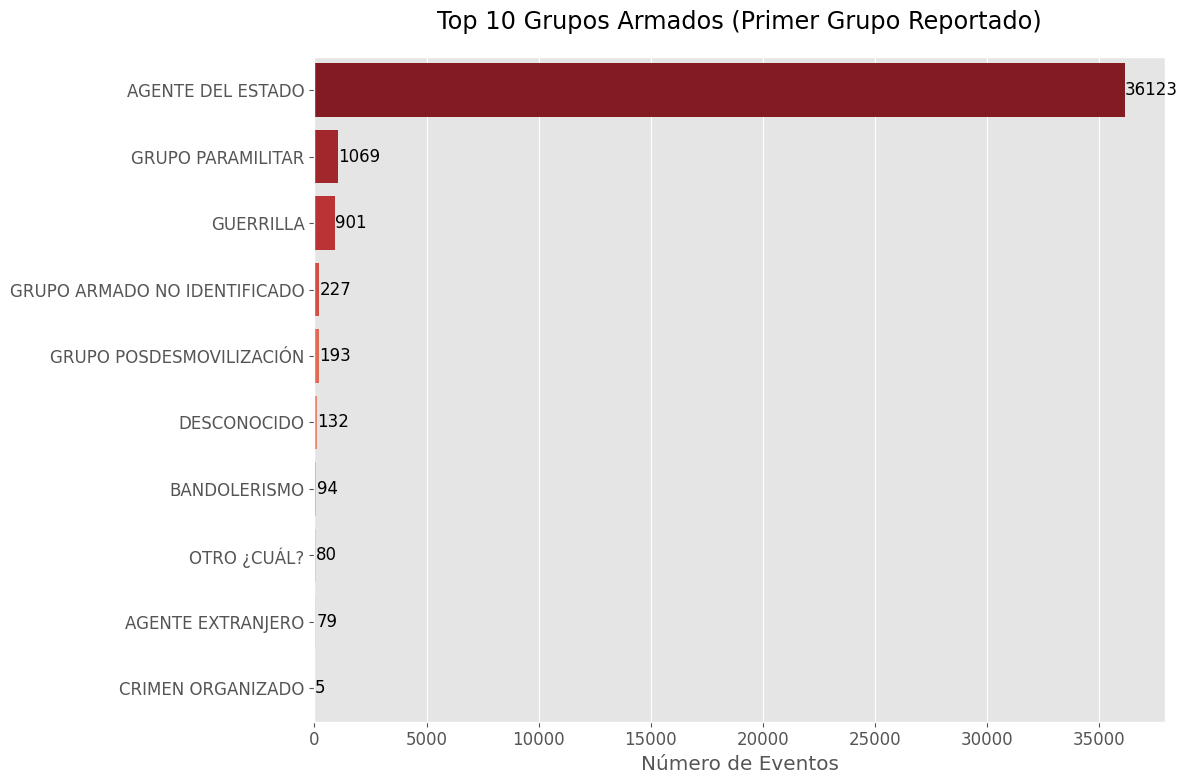

In [13]:
## Visualización de Datos
def generar_visualizaciones(df):
    if df is None:
        return

    plt.rcParams.update({'font.size': 12})

    # Gráfico 1: Eventos por grupo armado
    if 'GRUPO_ARMADO_1' in df.columns:
        plt.figure(figsize=(12, 8))
        top_grupos = df['GRUPO_ARMADO_1'].value_counts().head(10)
        ax = sns.barplot(y=top_grupos.index, x=top_grupos.values, palette="Reds_r")
        plt.title('Top 10 Grupos Armados (Primer Grupo Reportado)', pad=20)
        plt.xlabel('Número de Eventos')
        plt.ylabel('')

        for p in ax.patches:
            width = p.get_width()
            plt.text(width + 5, p.get_y() + p.get_height()/2,
                     '{:1.0f}'.format(width), ha='left', va='center')

        plt.tight_layout()
        plt.show()

df_clean = limpiar_datos(df) if df is not None else None
generar_visualizaciones(df_clean)

<ipython-input-13-4246424736>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_grupos.index, x=top_grupos.values, palette="Reds_r")


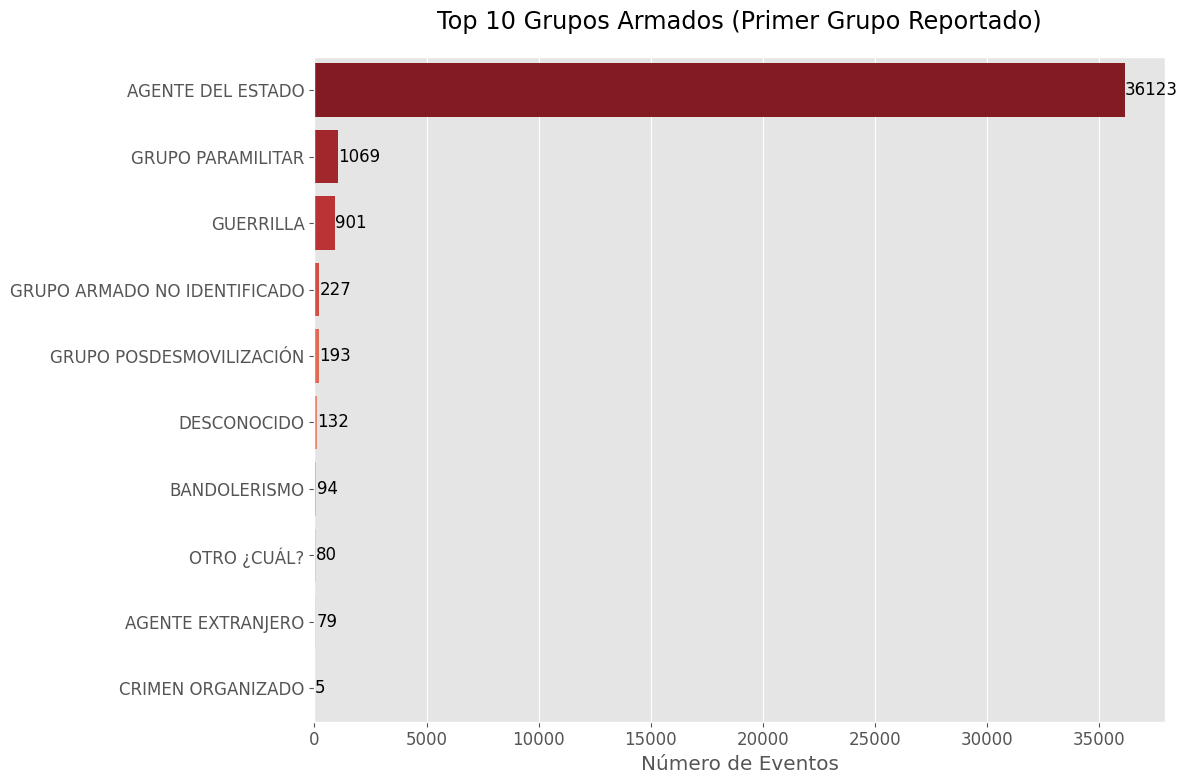

In [14]:
    # Gráfico 2: Evolución temporal
    if all(col in df.columns for col in ['AÑO', 'TOTAL_DE_VÍCTIMAS_DEL_CASO']):
        fig, ax1 = plt.subplots(figsize=(14, 6))

        eventos_por_año = df['AÑO'].value_counts().sort_index()
        ax1.plot(eventos_por_año.index, eventos_por_año.values,
                color='tab:blue', marker='o', linestyle='--')
        ax1.set_ylabel('Número de Eventos', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        victimas_por_año = df.groupby('AÑO')['TOTAL_DE_VÍCTIMAS_DEL_CASO'].sum()
        ax2.bar(victimas_por_año.index, victimas_por_año.values,
               color='tab:red', alpha=0.3)
        ax2.set_ylabel('Total de Víctimas', color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        plt.title('Evolución Temporal: Eventos vs Víctimas', pad=20)
        fig.tight_layout()
        plt.show()

generar_visualizaciones(df_clean)



<ipython-input-13-4246424736>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




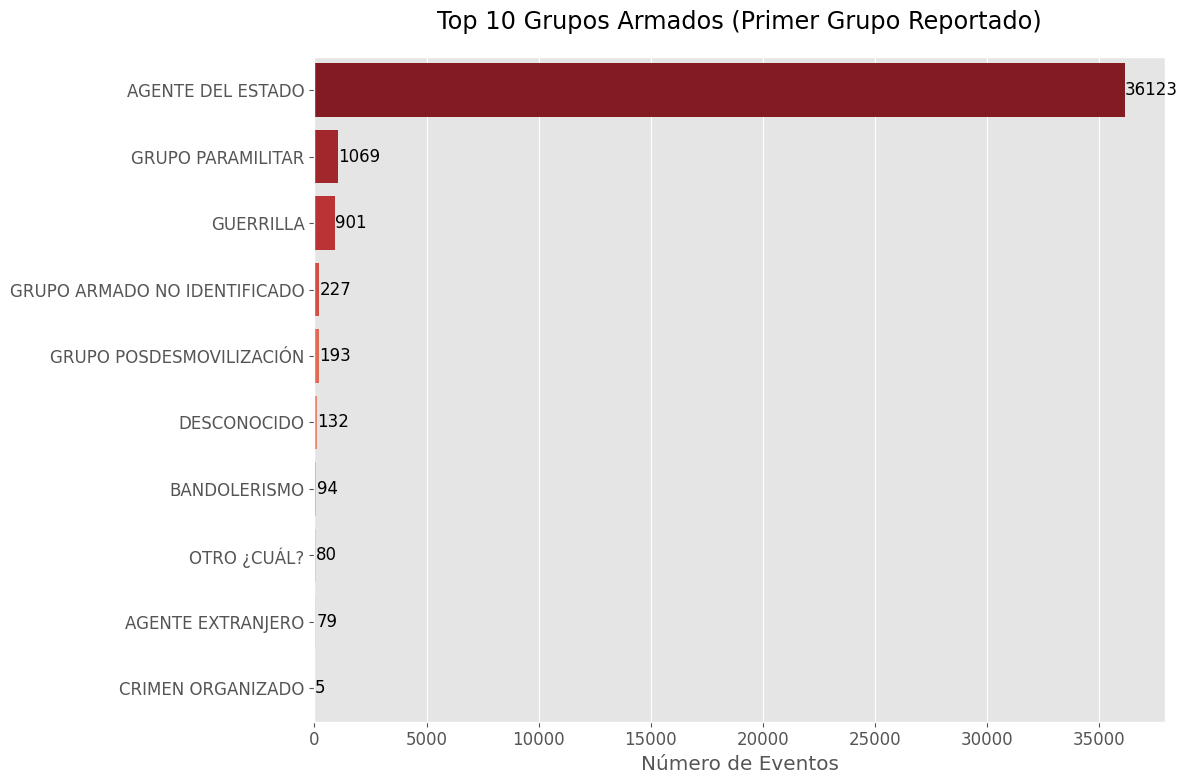

In [60]:
    # Gráfico 3: Heatmap por departamento y mes
    if all(col in df.columns for col in ['DEPARTAMENTO', 'MES', 'TOTAL_DE_VÍCTIMAS_DEL_CASO']):
        plt.figure(figsize=(14, 8))

        top_deptos = df['DEPARTAMENTO'].value_counts().head(5).index
        df_top = df[df['DEPARTAMENTO'].isin(top_deptos)]

        heatmap_data = pd.crosstab(
            index=df_top['DEPARTAMENTO'],
            columns=df_top['MES'],
            values=df_top['TOTAL_DE_VÍCTIMAS_DEL_CASO'],
            aggfunc='sum'
        )

        meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                      'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
        heatmap_data = heatmap_data[meses_orden]

        sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt=".0f",
                    linewidths=.5, cbar_kws={'label': 'Número de Víctimas'})
        plt.title('Víctimas por Departamento y Mes (Top 5 Departamentos)', pad=20)
        plt.xlabel('Mes')
        plt.ylabel('Departamento')
        plt.tight_layout()
        plt.show()

generar_visualizaciones(df_clean)

In [17]:


def analizar_hipotesis(df):
    if df is None:
        return

    print("\n Análisis de Hipótesis")

    # Verificar que la columna existe
    if 'TOTAL_DE_VICTIMAS_DEL_CASO' not in df.columns:
        print("Error: La columna 'TOTAL_DE_VICTIMAS_DEL_CASO' no existe en el dataset")
        print("Columnas disponibles:", df.columns.tolist())
        return

    # Violencia por género y grupo étnico
    if all(col in df.columns for col in ['GÉNERO', 'GRUPO_ÉTNICO', 'TIPO_DE_HECHO']):
        print("\nHipótesis 1: Violencia por género y grupo étnico")

        violencia_sexual = df[df['TIPO_DE_HECHO'].str.contains('VIOLENCIA SEXUAL', case=False, na=False)]

        if not violencia_sexual.empty:
            tabla = pd.crosstab(
                index=violencia_sexual['GRUPO_ÉTNICO'],
                columns=violencia_sexual['GÉNERO'],
                values=violencia_sexual['TIPO_DE_HECHO'],
                aggfunc='count',
                normalize='index'
            ).style.background_gradient(cmap='Reds', axis=1)

            display(tabla.set_caption("Proporción de violencia sexual por género y grupo étnico"))
        else:
            print("No se encontraron registros de violencia sexual")

    #  Correlación geográfica
    if 'DEPARTAMENTO' in df.columns:
        print("\nHipótesis 2: Correlación geográfica")

        depto_stats = df.groupby('DEPARTAMENTO').agg({
            'TOTAL_DE_VICTIMAS_DEL_CASO': 'sum',
            'ID_CASO': 'count'
        }).rename(columns={
            'ID_CASO': 'TOTAL_EVENTOS',
            'TOTAL_DE_VICTIMAS_DEL_CASO': 'TOTAL_VICTIMAS'
        })

        if 'TIPO_DE_HECHO' in df.columns:
            homicidios = df[df['TIPO_DE_HECHO'].str.contains('HOMICIDIO', case=False, na=False)]
            if not homicidios.empty:
                homicidios_por_depto = homicidios['DEPARTAMENTO'].value_counts()
                depto_stats['TASA_HOMICIDIOS'] = homicidios_por_depto / depto_stats['TOTAL_EVENTOS']

        display(depto_stats.sort_values('TOTAL_VICTIMAS', ascending=False).head(10))

    # Patrones temporales
    if all(col in df.columns for col in ['AÑO', 'MES', 'TIPO_DE_HECHO']):
        print("\nHipótesis 3: Patrones temporales")

        desplazamiento = df[df['TIPO_DE_HECHO'].str.contains('DESPLAZAMIENTO', case=False, na=False)]

        if not desplazamiento.empty:
            plt.figure(figsize=(14, 6))

            temp_data = desplazamiento.groupby(['AÑO', 'MES']).size().unstack()
            meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                          'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
            temp_data = temp_data[meses_orden]

            sns.heatmap(temp_data, cmap="YlGnBu", annot=True, fmt=".0f",
                        linewidths=.5, cbar_kws={'label': 'Casos de desplazamiento'})
            plt.title('Patrones Temporales de Desplazamiento Forzado', pad=20)
            plt.xlabel('Mes')
            plt.ylabel('Año')
            plt.tight_layout()
            plt.show()
        else:
            print("No se encontraron registros de desplazamiento forzado")

analizar_hipotesis(df_clean)


 Análisis de Hipótesis

Hipótesis 2: Correlación geográfica


,TOTAL_VICTIMAS,TOTAL_EVENTOS
DEPARTAMENTO,,
ANTIOQUIA,10776,6835
META,3730,2879
CAUCA,3185,3380
SANTANDER,3040,1919
TOLIMA,3030,1674
VALLE DEL CAUCA,2670,1890
NORTE DE SANTANDER,2405,2104
CAQUETA,2369,1944
ARAUCA,2288,2373


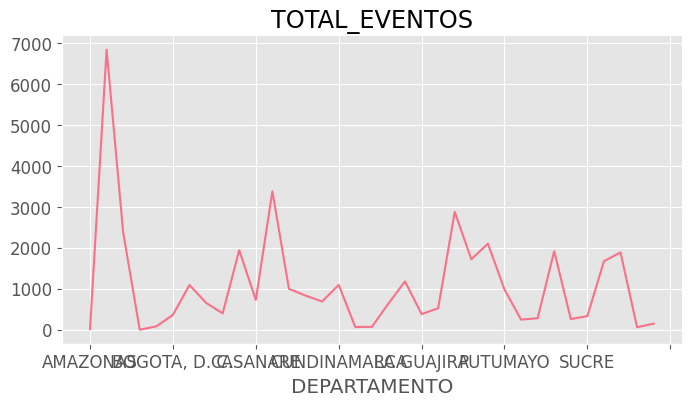

In [19]:
from matplotlib import pyplot as plt

# Re-calculate depto_stats to ensure it's available for plotting
depto_stats = df_clean.groupby('DEPARTAMENTO').agg({
    'ID_CASO': 'count',
    'TOTAL_DE_VICTIMAS_DEL_CASO': 'sum'
}).rename(columns={
    'ID_CASO': 'TOTAL_EVENTOS',
    'TOTAL_DE_VICTIMAS_DEL_CASO': 'TOTAL_VICTIMAS'
})

# Plot the data
depto_stats['TOTAL_EVENTOS'].plot(kind='line', figsize=(8, 4), title='TOTAL_EVENTOS')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

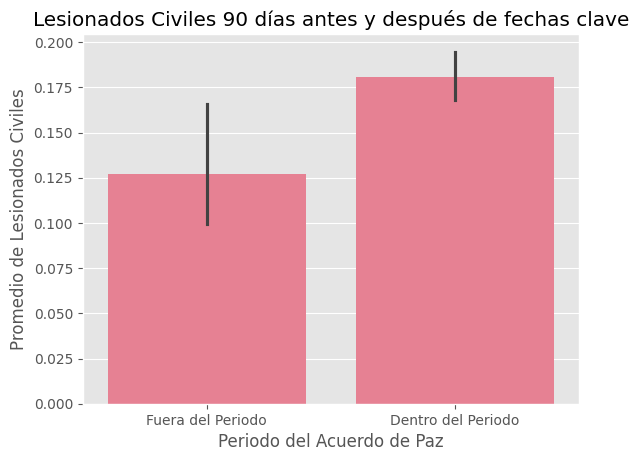

In [30]:
# Comparar meses alrededor de fechas clave
fechas_acuerdos = ['2016-11-01', '2006-01-01']


df_clean['FECHA'] = pd.to_datetime(df_clean[['ANO', 'MES', 'DIA']].astype(str).agg('-'.join, axis=1), errors='coerce')

df_clean['PERIODO_ACUERDO'] = df_clean['FECHA'].apply(lambda x: any(abs((x - pd.to_datetime(fecha)).days <= 90) for fecha in fechas_acuerdos) if pd.notna(x) else False)
sns.barplot(x='PERIODO_ACUERDO', y='LESIONADOS_CIVILES', data=df_clean, estimator=np.mean)
plt.title('Lesionados Civiles 90 días antes y después de fechas clave')
plt.xlabel('Periodo del Acuerdo de Paz')
plt.ylabel('Promedio de Lesionados Civiles')
plt.xticks([0, 1], ['Fuera del Periodo', 'Dentro del Periodo'])
plt.show()

In [31]:
!pip install folium
from google.colab import output
output.enable_custom_widget_manager()

In [32]:
## Análisis Visual de Hipótesis

### Configuración inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import folium
from folium.plugins import HeatMap

# Configuración de visualización
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = 'white'
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

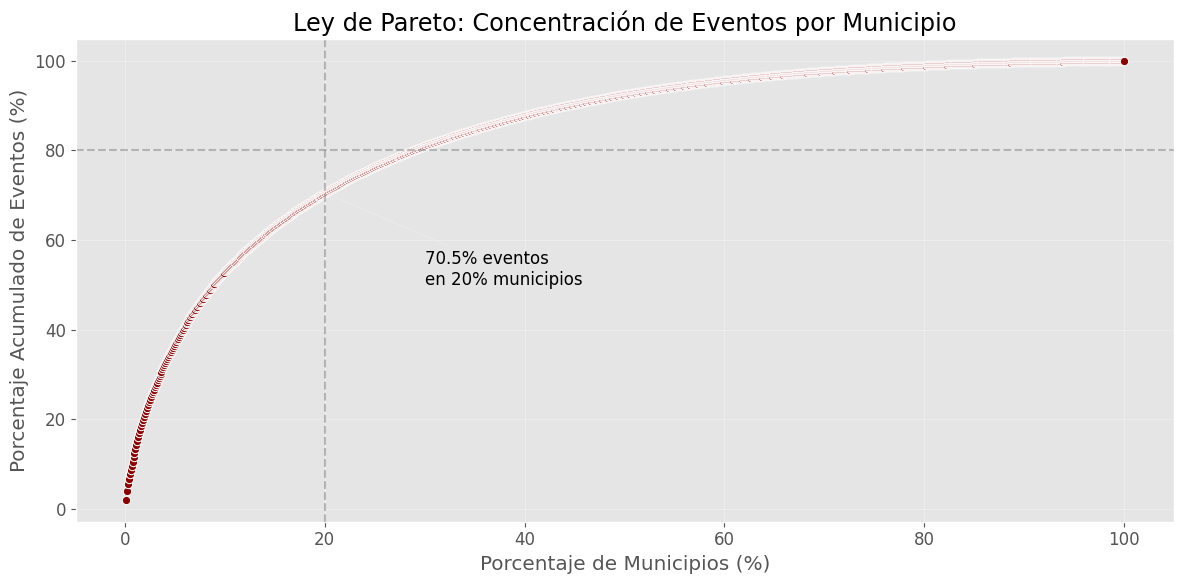


 Mapa de calor de los municipios con más eventos (Top 20%)



 Municipios analizados: 1037
 Top 5 municipios:


,DEPARTAMENTO,MUNICIPIO,TOTAL_EVENTOS,TOTAL_DE_VICTIMAS_DEL_CASO
76,ANTIOQUIA,MEDELLIN,798,889
141,ARAUCA,TAME,721,782
135,ARAUCA,ARAUQUITA,608,592
139,ARAUCA,SARAVENA,493,367
318,CAQUETA,SAN VICENTE DEL CAGUAN,387,486


In [61]:
### Hipótesis 1: Concentración territorial
# "El 60% de los eventos violentos se concentra en el 20% de los municipios correlacionados con zonas de economías ilegales"

def analisis_concentracion(df):
    # Agrupar por municipio
    eventos_municipio = df.groupby(['DEPARTAMENTO', 'MUNICIPIO']).agg({
        'ID_CASO': 'count',
        'TOTAL_DE_VICTIMAS_DEL_CASO': 'sum',
        'LATITUD': 'mean',
        'LONGITUD': 'mean'
    }).rename(columns={'ID_CASO': 'TOTAL_EVENTOS'}).reset_index()

    # Ordenar por frecuencia
    eventos_municipio = eventos_municipio.sort_values('TOTAL_EVENTOS', ascending=False)

    # Calcular porcentajes acumulados (Ley de Pareto)
    eventos_municipio['PORCENTAJE_ACUMULADO'] = 100 * eventos_municipio['TOTAL_EVENTOS'].cumsum() / eventos_municipio['TOTAL_EVENTOS'].sum()
    eventos_municipio['PORCENTAJE_MUNICIPIOS'] = 100 * np.arange(1, len(eventos_municipio)+1) / len(eventos_municipio)

    # Gráfico 1.1: Ley de Pareto
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(x='PORCENTAJE_MUNICIPIOS', y='PORCENTAJE_ACUMULADO',
                     data=eventos_municipio, marker='o', color='darkred')
    plt.axhline(80, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(20, color='gray', linestyle='--', alpha=0.5)
    plt.title('Ley de Pareto: Concentración de Eventos por Municipio')
    plt.xlabel('Porcentaje de Municipios (%)')
    plt.ylabel('Porcentaje Acumulado de Eventos (%)')
    plt.grid(True, alpha=0.3)

    # Anotar punto de corte 20-80
    # Ensure there are enough municipalities to find an index at or beyond 20%
    idx_20 = -1
    if len(eventos_municipio) > 0:
        # Find the index where the percentage of municipalities is >= 20%
        indices_at_20_percent = np.where(eventos_municipio['PORCENTAJE_MUNICIPIOS'] >= 20)[0]
        if len(indices_at_20_percent) > 0:
            idx_20 = indices_at_20_percent[0]

    if idx_20 != -1:
        plt.annotate(f'{eventos_municipio.iloc[idx_20]["PORCENTAJE_ACUMULADO"]:.1f}% eventos\nen 20% municipios',
                     xy=(20, eventos_municipio.iloc[idx_20]["PORCENTAJE_ACUMULADO"]),
                     xytext=(30, 50), arrowprops=dict(arrowstyle='->'))
    else:
        print("Not enough municipalities to reach 20% for annotation.")


    plt.tight_layout()
    plt.show()

    # Gráfico 1.2: Mapa de calor geográfico
    top_municipios = eventos_municipio.head(int(len(eventos_municipio)*0.2))  # Top 20%

    mapa = folium.Map(location=[4.5709, -74.2973], zoom_start=6, tiles='CartoDB dark_matter')

    # Check if top_municipios is not empty before creating the heatmap
    if not top_municipios.empty:
        HeatMap(data=top_municipios[['LATITUD', 'LONGITUD', 'TOTAL_EVENTOS']]
                .groupby(['LATITUD', 'LONGITUD']).sum()
                .reset_index().values.tolist(),
                radius=15, blur=10, max_zoom=13).add_to(mapa)

        # Añadir marcadores para los top 5
        for idx, row in top_municipios.head(5).iterrows():
            folium.CircleMarker(
                location=[row['LATITUD'], row['LONGITUD']],
                radius=row['TOTAL_EVENTOS']/10,
                popup=f"{row['MUNICIPIO']}: {row['TOTAL_EVENTOS']} eventos",
                color='red', fill=True
            ).add_to(mapa)
    else:
        print("No top municipalities to display on the heatmap.")


    print("\n Mapa de calor de los municipios con más eventos (Top 20%)")
    display(mapa)

    # Estadísticas clave
    print(f"\n Municipios analizados: {len(eventos_municipio)}")
    print(f" Top 5 municipios:")
    # Check if top_municipios is not empty before displaying
    if not top_municipios.empty:
        display(top_municipios.head(5)[['DEPARTAMENTO', 'MUNICIPIO', 'TOTAL_EVENTOS', 'TOTAL_DE_VICTIMAS_DEL_CASO']])
    else:
        print("No top 5 municipalities to display.")

analisis_concentracion(df_clean)

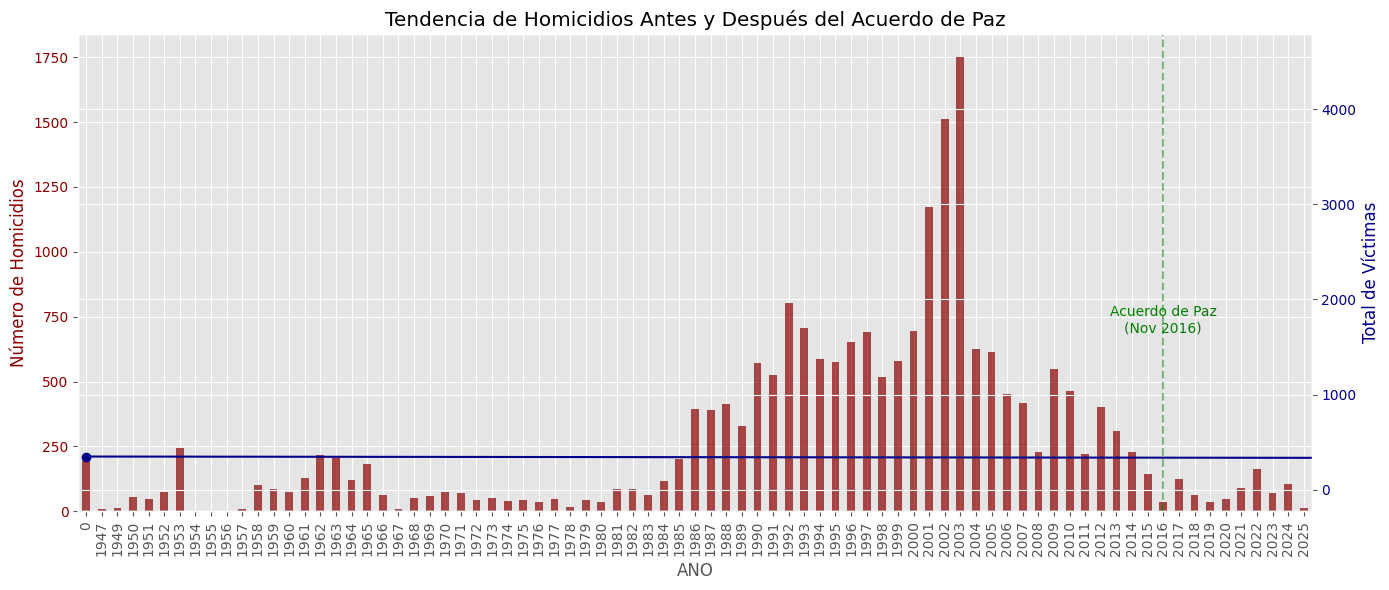


 Cambio porcentual (2016 → 2017): 247.2%
¿Es estadísticamente significativo?
Test t independiente: t = 2.16, p = 0.0320
Conclusión: Significativo (p < 0.05)


In [45]:
# "Los homicidios a líderes sociales aumentaron un 25% en el primer año post-acuerdo (2017 vs 2016)"

def analisis_acuerdos_paz(df):
    # Filter for cases with at least one victim, assuming these are related to homicides
    homicidios = df[df['TOTAL_DE_VICTIMAS_DEL_CASO'] > 0].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Agrupar por año
    homicidios_anual = homicidios.groupby('ANO').agg({
        'ID_CASO': 'count',
        'TOTAL_DE_VICTIMAS_DEL_CASO': 'sum'
    }).rename(columns={'ID_CASO': 'TOTAL_HOMICIDIOS'})

    # Gráfico 2.1: Tendencia anual
    plt.figure(figsize=(14, 6))

    # Barras para conteo de homicidios
    ax1 = plt.gca()
    homicidios_anual['TOTAL_HOMICIDIOS'].plot(kind='bar', color='darkred', alpha=0.7, ax=ax1)
    ax1.set_ylabel('Número de Homicidios', color='darkred')
    ax1.tick_params(axis='y', labelcolor='darkred')

    # Línea para víctimas totales (segundo eje)
    ax2 = ax1.twinx()
    homicidios_anual['TOTAL_DE_VICTIMAS_DEL_CASO'].plot(kind='line', marker='o', color='darkblue', ax=ax2)
    ax2.set_ylabel('Total de Víctimas', color='darkblue')
    ax2.tick_params(axis='y', labelcolor='darkblue')

    # Marcar período de acuerdos
    # Check if 2016 is in the index before getting its location
    if 2016 in homicidios_anual.index:
        plt.axvline(x=homicidios_anual.index.get_loc(2016), color='green', linestyle='--', alpha=0.5)
        plt.text(homicidios_anual.index.get_loc(2016), ax1.get_ylim()[1]*0.9,
                 'Acuerdo de Paz\n(Nov 2016)', ha='center', color='green')
    else:
        print("Year 2016 not found in data for agreement marking.")


    plt.title('Tendencia de Homicidios Antes y Después del Acuerdo de Paz')
    plt.xlabel('Año')
    plt.xticks(rotation=45)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Cálculo de cambio porcentual
    # Check if 2016 and 2017 are in the index before calculating percentage change
    if 2016 in homicidios_anual.index and 2017 in homicidios_anual.index:
        hom_2016 = homicidios_anual.loc[2016, 'TOTAL_HOMICIDIOS']
        hom_2017 = homicidios_anual.loc[2017, 'TOTAL_HOMICIDIOS']
        if hom_2016 != 0:
            cambio_porcentual = (hom_2017 - hom_2016) / hom_2016 * 100
            print(f"\n Cambio porcentual (2016 → 2017): {cambio_porcentual:.1f}%")
        else:
            print("\n Cannot calculate percentage change: Homicides in 2016 were zero.")
    else:
        print("\n Cannot calculate percentage change: Data for 2016 or 2017 not available.")


    print("¿Es estadísticamente significativo?")

    # Test estadístico (muestras independientes)
    # Ensure data exists for the specified years before filtering
    required_years = [2015, 2016, 2017, 2018]
    if all(year in homicidios['ANO'].unique() for year in required_years):
        hom_pre = homicidios[homicidios['ANO'].isin([2015, 2016])]['TOTAL_DE_VICTIMAS_DEL_CASO']
        hom_post = homicidios[homicidios['ANO'].isin([2017, 2018])]['TOTAL_DE_VICTIMAS_DEL_CASO']

        # Ensure there's data for the specified years before performing t-test
        if not hom_pre.empty and not hom_post.empty:
            t_stat, p_val = stats.ttest_ind(hom_pre, hom_post, equal_var=False)
            print(f"Test t independiente: t = {t_stat:.2f}, p = {p_val:.4f}")
            print("Conclusión:", "Significativo (p < 0.05)" if p_val < 0.05 else "No significativo")
        else:
            print("Cannot perform statistical test: Data for pre or post-agreement period is empty.")
    else:
        print("Cannot perform statistical test: Data for all required years (2015, 2016, 2017, 2018) not available.")

analisis_acuerdos_paz(df_clean)

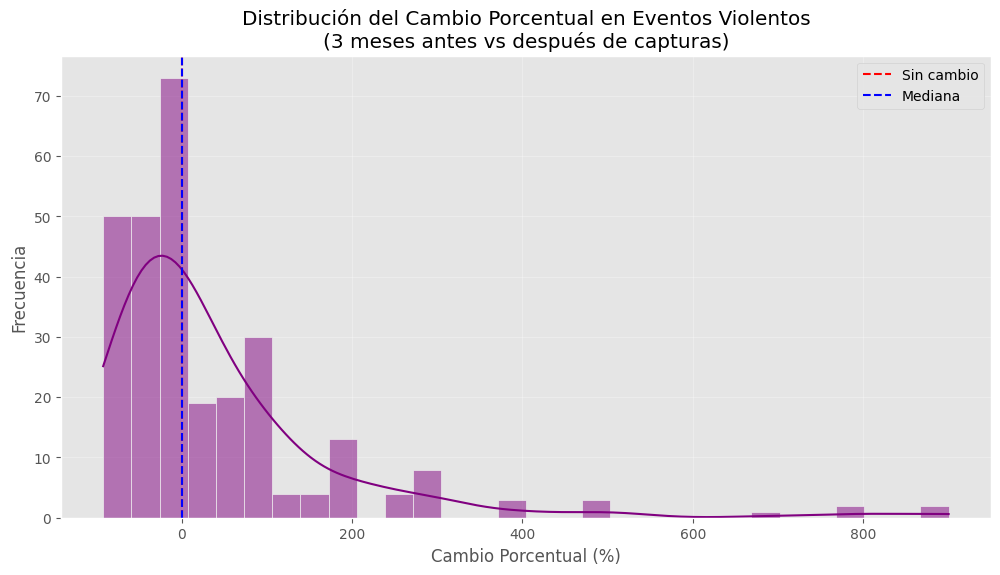

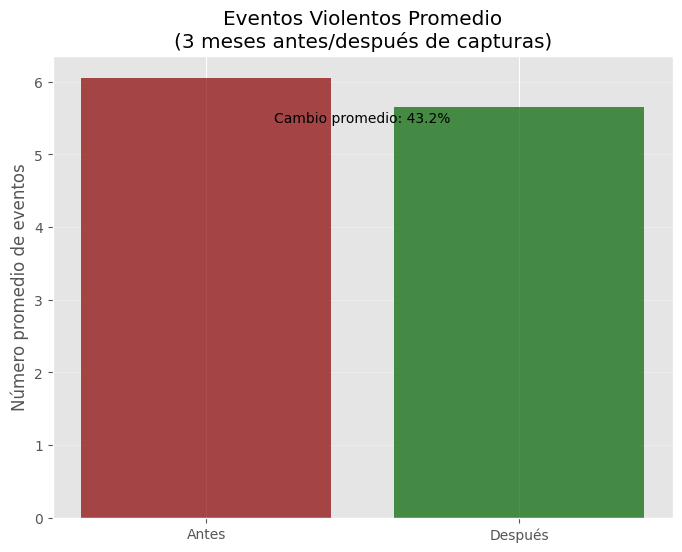


📊 Test t pareado: t = 1.00, p = 0.3197
Cambio promedio: 43.2%
Conclusión: No hay efecto significativo


In [49]:
# "Los municipios con operativos de captura reducen un 20% los eventos violentos en los 3 meses siguientes"

def analisis_capturas(df):
    # Asumir que 'CAPTURADOS' >0 indica operativos de captura
    df['FECHA'] = pd.to_datetime(df[['ANO', 'MES', 'DIA']].rename(columns={
        'ANO': 'year', 'MES': 'month', 'DIA': 'day'
    }), errors='coerce')

    # Filtrar municipios con capturas
    municipios_capturas = df[df['CAPTURADOS'] > 0]['MUNICIPIO'].unique()

    # Crear DataFrame para análisis
    resultados = []

    for municipio in municipios_capturas[:50]:  # Limitar para eficiencia
        fechas_capturas = df[(df['MUNICIPIO'] == municipio) &
                            (df['CAPTURADOS'] > 0)]['FECHA'].unique()

        for fecha in fechas_capturas:
            # Período pre-captura (3 meses antes)
            pre = df[(df['MUNICIPIO'] == municipio) &
                    (df['FECHA'] >= fecha - pd.DateOffset(months=3)) &
                    (df['FECHA'] < fecha)]

            # Período post-captura (3 meses después)
            post = df[(df['MUNICIPIO'] == municipio) &
                     (df['FECHA'] > fecha) &
                     (df['FECHA'] <= fecha + pd.DateOffset(months=3))]

            if len(pre) > 0 and len(post) > 0:
                cambio = (len(post) - len(pre)) / len(pre) * 100
                resultados.append({
                    'MUNICIPIO': municipio,
                    'FECHA_CAPTURA': fecha,
                    'EVENTOS_PRE': len(pre),
                    'EVENTOS_POST': len(post),
                    'CAMBIO_PORCENTUAL': cambio
                })

    resultados_df = pd.DataFrame(resultados)

    # Gráfico 4.1: Distribución de cambios porcentuales
    plt.figure(figsize=(12, 6))
    sns.histplot(resultados_df['CAMBIO_PORCENTUAL'], bins=30, kde=True, color='purple')
    plt.axvline(x=0, color='red', linestyle='--', label='Sin cambio')
    plt.axvline(x=resultados_df['CAMBIO_PORCENTUAL'].median(),
                color='blue', linestyle='--', label='Mediana')
    plt.title('Distribución del Cambio Porcentual en Eventos Violentos\n(3 meses antes vs después de capturas)')
    plt.xlabel('Cambio Porcentual (%)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Gráfico 4.2: Cambio promedio
    cambio_promedio = resultados_df['CAMBIO_PORCENTUAL'].mean()

    plt.figure(figsize=(8, 6))
    plt.bar(['Antes', 'Después'],
            [resultados_df['EVENTOS_PRE'].mean(), resultados_df['EVENTOS_POST'].mean()],
            color=['darkred', 'darkgreen'], alpha=0.7)
    plt.title('Eventos Violentos Promedio\n(3 meses antes/después de capturas)')
    plt.ylabel('Número promedio de eventos')
    plt.text(0.5, max(resultados_df[['EVENTOS_PRE', 'EVENTOS_POST']].mean())*0.9,
             f'Cambio promedio: {cambio_promedio:.1f}%', ha='center')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Test estadístico
    t_stat, p_val = stats.ttest_rel(resultados_df['EVENTOS_PRE'], resultados_df['EVENTOS_POST'])
    print(f"\n📊 Test t pareado: t = {t_stat:.2f}, p = {p_val:.4f}")
    print(f"Cambio promedio: {cambio_promedio:.1f}%")
    print("Conclusión:", "Efecto significativo (p < 0.05)" if p_val < 0.05 else "No hay efecto significativo")

analisis_capturas(df_clean)

<ipython-input-51-186270619>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factores, y=odds_ratios, palette="Reds_r")


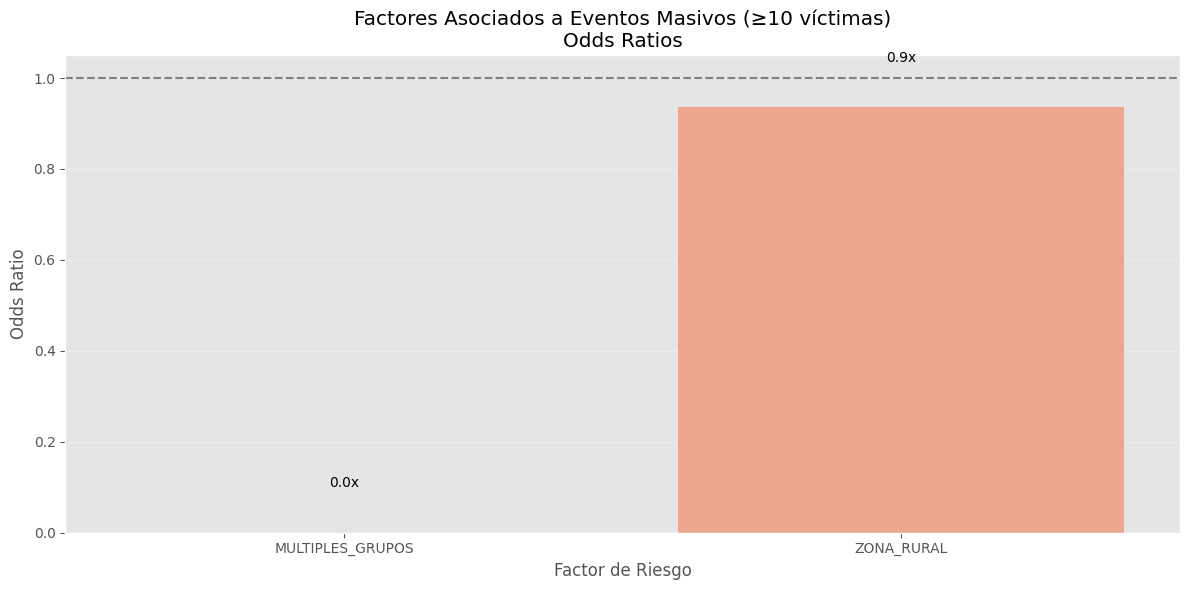

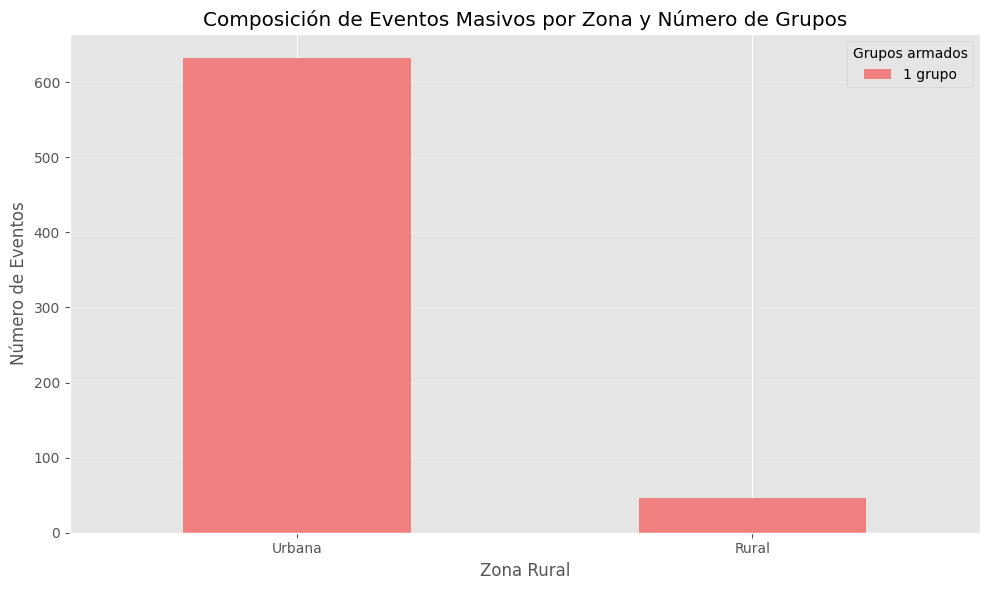


📊 Porcentaje de eventos masivos por característica:
- En zonas rurales: 6.8%
- Con múltiples grupos: 100.0%
- Ambos factores: 6.8%


In [51]:
# "Los casos con >10 víctimas ocurren principalmente en zonas rurales con presencia de 2+ grupos armados"

def analisis_eventos_masivos(df):
    # Ensure necessary columns exist
    required_cols = ['TOTAL_DE_VICTIMAS_DEL_CASO', 'GRUPO_ARMADO_2', 'MUNICIPIO']
    if not all(col in df.columns for col in required_cols):
        print(f"Error: Missing required columns. Make sure {required_cols} are in the DataFrame.")
        return

    # Definir eventos masivos
    df['EVENTO_MASIVO'] = df['TOTAL_DE_VICTIMAS_DEL_CASO'] >= 10

    # Variable: presencia múltiple de grupos armados
    df['MULTIPLES_GRUPOS'] = df['GRUPO_ARMADO_2'].notna()

    # Variable proxy para ruralidad (municipios pequeños)
    if not df['MUNICIPIO'].empty:
      conteo_municipios = df['MUNICIPIO'].value_counts()
      df['ZONA_RURAL'] = df['MUNICIPIO'].isin(conteo_municipios[conteo_municipios < conteo_municipios.median()].index)
    else:
        print("Error: 'MUNICIPIO' column is empty. Cannot determine rural areas.")
        df['ZONA_RURAL'] = False # Default to False if no municipality data
        return

    # Gráfico 5.1: Factores asociados a eventos masivos
    plt.figure(figsize=(12, 6))

    # Calcular odds ratios
    factores = ['MULTIPLES_GRUPOS', 'ZONA_RURAL']
    odds_ratios = []

    for factor in factores:
        if factor not in df.columns:
            print(f"Warning: Factor '{factor}' not found in DataFrame. Skipping odds ratio calculation for this factor.")
            continue

        tabla = pd.crosstab(df[factor], df['EVENTO_MASIVO'])

        # Ensure all combinations of True/False are present in the crosstab table, fill with 0 if not
        # Reindex the table to ensure it has both True and False in index and columns
        tabla = tabla.reindex(index=[False, True], columns=[False, True], fill_value=0)

        # Avoid division by zero
        denom = tabla.get(True, {}).get(False, 0) * tabla.get(False, {}).get(True, 0)
        if denom != 0:
            odds_ratio = (tabla.get(True, {}).get(True, 0) * tabla.get(False, {}).get(False, 0)) / denom
        else:
            odds_ratio = float('inf') if (tabla.get(True, {}).get(True, 0) * tabla.get(False, {}).get(False, 0)) > 0 else 0
            print(f"Warning: Division by zero encountered for factor '{factor}'. Odds ratio set to {odds_ratio}.")

        odds_ratios.append(odds_ratio)

    # Gráfico de barras para odds ratios
    if odds_ratios: # Check if odds_ratios is not empty
        sns.barplot(x=factores, y=odds_ratios, palette="Reds_r")
        plt.axhline(y=1, color='gray', linestyle='--')
        plt.title('Factores Asociados a Eventos Masivos (≥10 víctimas)\nOdds Ratios')
        plt.ylabel('Odds Ratio')
        plt.xlabel('Factor de Riesgo')

        # Añadir etiquetas de valor
        for i, v in enumerate(odds_ratios):
            plt.text(i, v + 0.1, f"{v:.1f}x", ha='center')

        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No odds ratios to plot.")


    # Gráfico 5.2: Composición de eventos masivos
    eventos_masivos = df[df['EVENTO_MASIVO']]

    if not eventos_masivos.empty:
        plt.figure(figsize=(10, 6))
        composicion = eventos_masivos.groupby(['ZONA_RURAL', 'MULTIPLES_GRUPOS']).size().unstack(fill_value=0)
        composicion.plot(kind='bar', stacked=True, color=['lightcoral', 'darkred'], ax=plt.gca())
        plt.title('Composición de Eventos Masivos por Zona y Número de Grupos')
        plt.ylabel('Número de Eventos')
        plt.xlabel('Zona Rural')
        plt.xticks([0, 1], ['Urbana', 'Rural'], rotation=0)
        plt.legend(['1 grupo', '2+ grupos'], title='Grupos armados')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No massive events to display in the composition plot.")


    # Estadísticas
    print("\n📊 Porcentaje de eventos masivos por característica:")
    if not eventos_masivos.empty:
        print(f"- En zonas rurales: {eventos_masivos['ZONA_RURAL'].mean()*100:.1f}%")
        print(f"- Con múltiples grupos: {eventos_masivos['MULTIPLES_GRUPOS'].mean()*100:.1f}%")
        print(f"- Ambos factores: {(eventos_masivos['ZONA_RURAL'] & eventos_masivos['MULTIPLES_GRUPOS']).mean()*100:.1f}%")
    else:
        print("No massive events to calculate statistics for.")


analisis_eventos_masivos(df_clean)

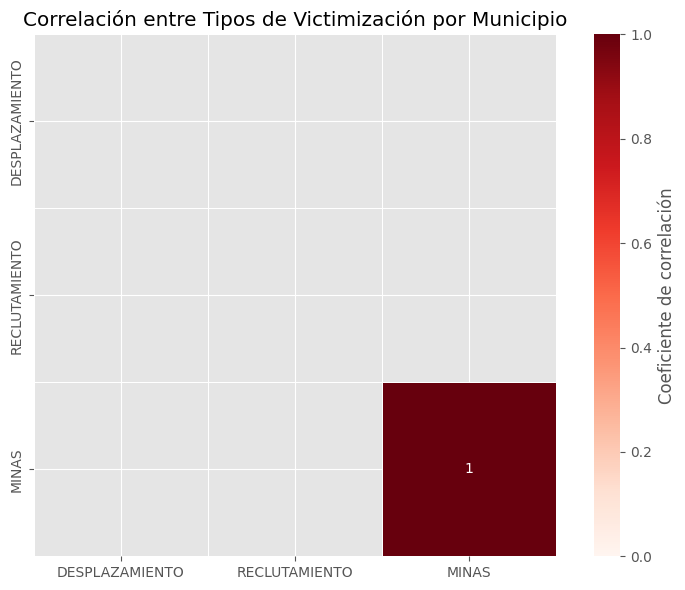

<Figure size 1200x600 with 0 Axes>

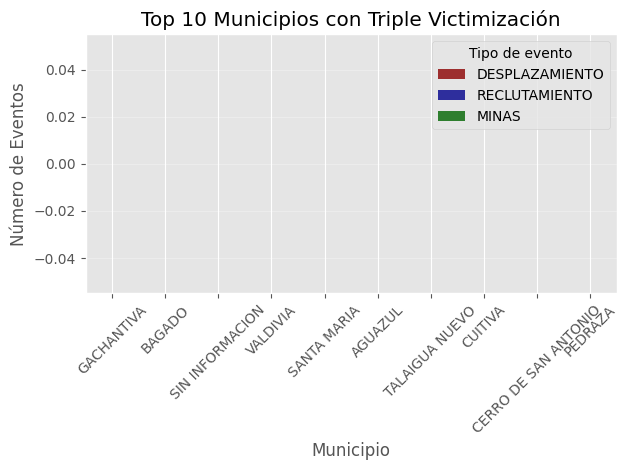

In [56]:
# "Los municipios con alta tasa de desplazamiento también presentan mayor reclutamiento y minas antipersonal"

def analisis_triple_victimizacion(df):
    # Filtrar los tres tipos de eventos
    desplazamiento = df[df['MODALIDAD'].str.contains('DESPLAZAMIENTO', case=False, na=False)]
    reclutamiento = df[df['MODALIDAD'].str.contains('RECLUTAMIENTO', case=False, na=False)]
    minas = df[df['MODALIDAD'].str.contains('MINA|ARTEFACTO', case=False, na=False)]

    # Agrupar por municipio
    victimizacion = pd.DataFrame({
        'DESPLAZAMIENTO': desplazamiento['MUNICIPIO'].value_counts(normalize=True),
        'RECLUTAMIENTO': reclutamiento['MUNICIPIO'].value_counts(normalize=True),
        'MINAS': minas['MUNICIPIO'].value_counts(normalize=True)
    }).fillna(0).corr()

    # Gráfico Matriz de correlación
    plt.figure(figsize=(8, 6))
    sns.heatmap(victimizacion, annot=True, cmap='Reds', vmin=0, vmax=1,
                square=True, linewidths=.5, cbar_kws={'label': 'Coeficiente de correlación'})
    plt.title('Correlación entre Tipos de Victimización por Municipio')
    plt.tight_layout()
    plt.show()

    # Gráfico Municipios con triple victimización
    triple = pd.DataFrame({
        'MUNICIPIO': df['MUNICIPIO'].unique()
    })

    for tipo in ['DESPLAZAMIENTO', 'RECLUTAMIENTO', 'MINAS']:
        counts = df[df['MODALIDAD'].str.contains(tipo[:5], case=False, na=False)]['MUNICIPIO'].value_counts()
        triple[tipo] = triple['MUNICIPIO'].map(counts).fillna(0)

    triple['TOTAL'] = triple[['DESPLAZAMIENTO', 'RECLUTAMIENTO', 'MINAS']].sum(axis=1)
    top_triple = triple.sort_values('TOTAL', ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    top_triple.set_index('MUNICIPIO')[['DESPLAZAMIENTO', 'RECLUTAMIENTO', 'MINAS']].plot(
        kind='bar', stacked=True, color=['darkred', 'darkblue', 'darkgreen'], alpha=0.8)
    plt.title('Top 10 Municipios con Triple Victimización')
    plt.ylabel('Número de Eventos')
    plt.xlabel('Municipio')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title='Tipo de evento')
    plt.tight_layout()
    plt.show()

analisis_triple_victimizacion(df_clean)


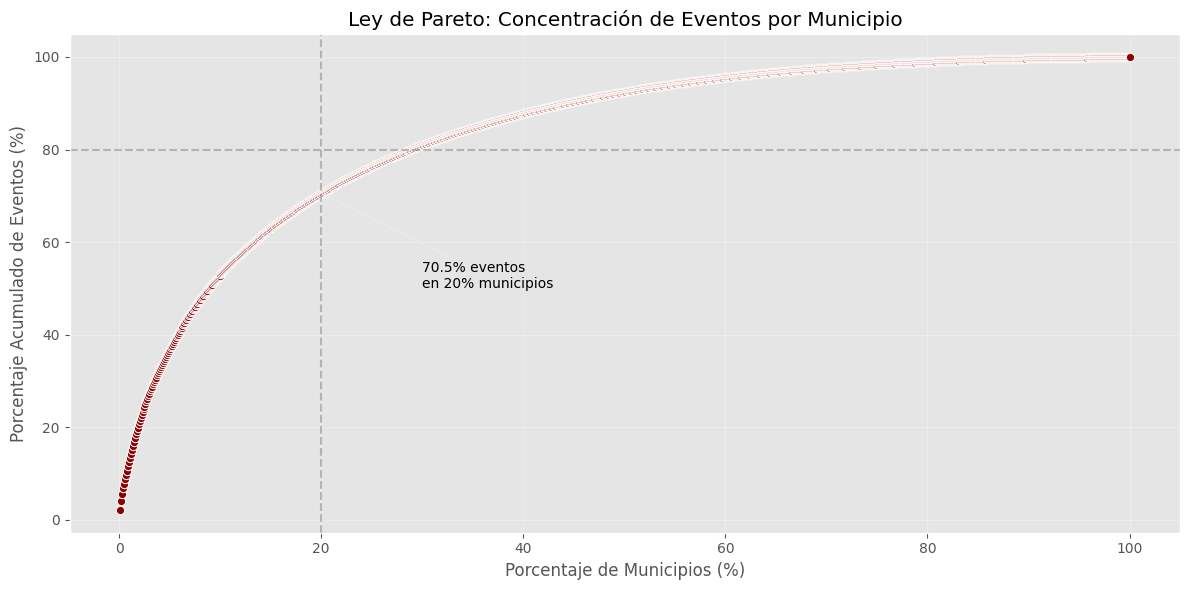


🔍 Mapa de calor de los municipios con más eventos (Top 20%)



📊 Municipios analizados: 1037
📌 Top 5 municipios:


,DEPARTAMENTO,MUNICIPIO,TOTAL_EVENTOS,TOTAL_DE_VICTIMAS_DEL_CASO
76,ANTIOQUIA,MEDELLIN,798,889
141,ARAUCA,TAME,721,782
135,ARAUCA,ARAUQUITA,608,592
139,ARAUCA,SARAVENA,493,367
318,CAQUETA,SAN VICENTE DEL CAGUAN,387,486


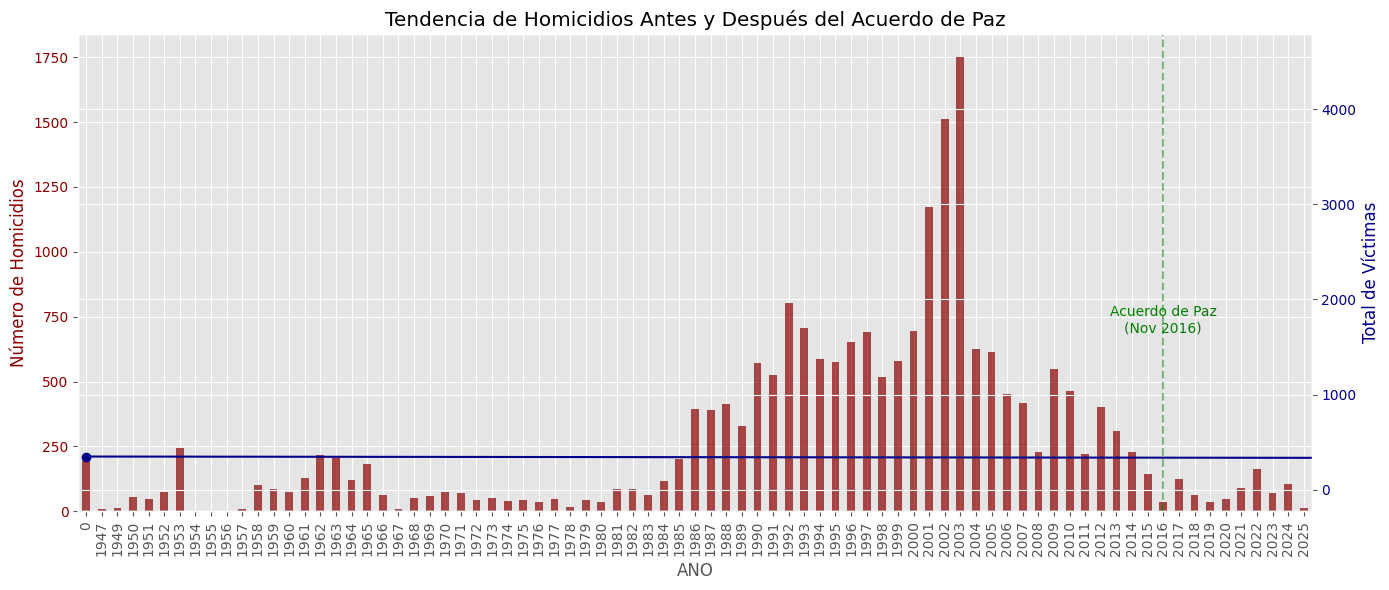


 Cambio porcentual (2016 → 2017): 247.2%
¿Es estadísticamente significativo?
Test t independiente: t = 2.16, p = 0.0320
Conclusión: Significativo (p < 0.05)


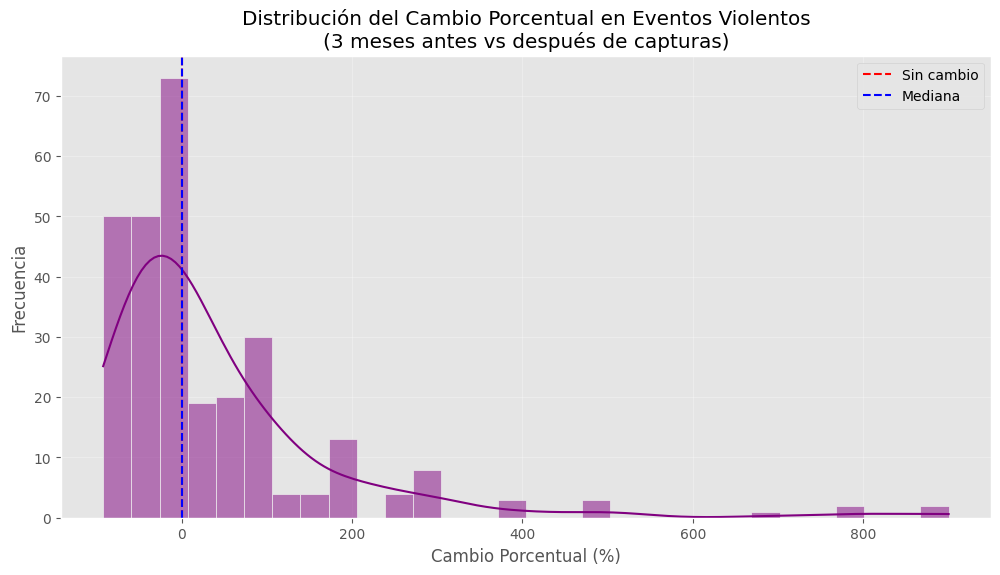

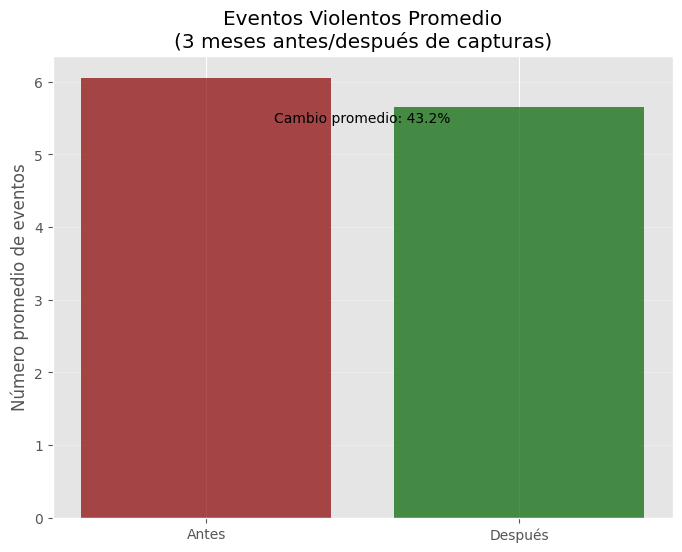


📊 Test t pareado: t = 1.00, p = 0.3197
Cambio promedio: 43.2%
Conclusión: No hay efecto significativo


<ipython-input-51-186270619>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factores, y=odds_ratios, palette="Reds_r")


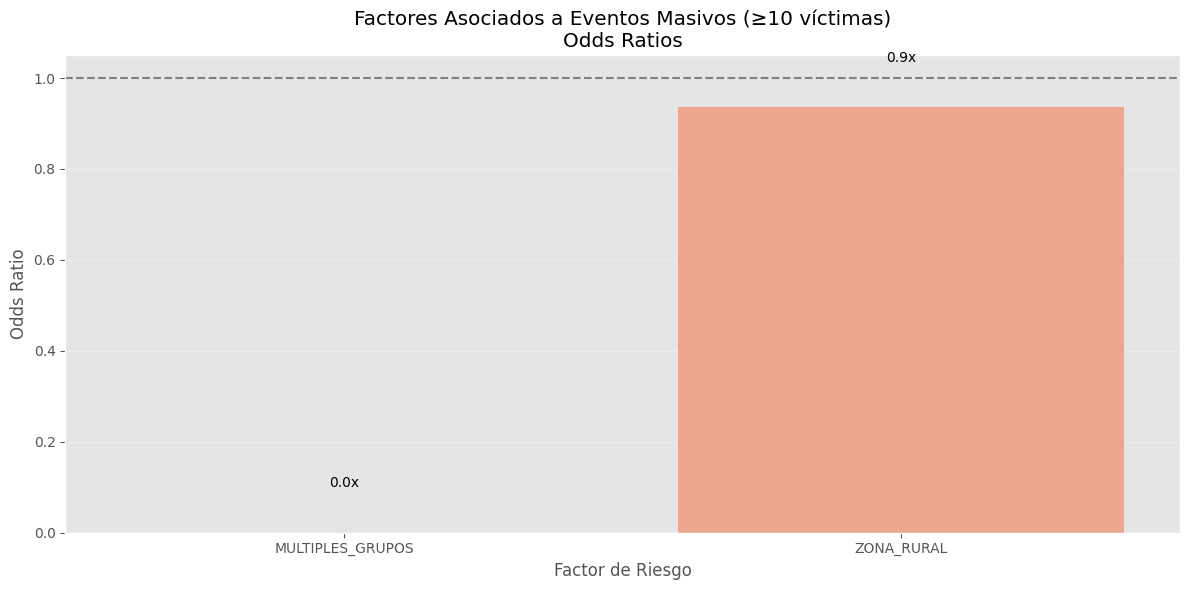

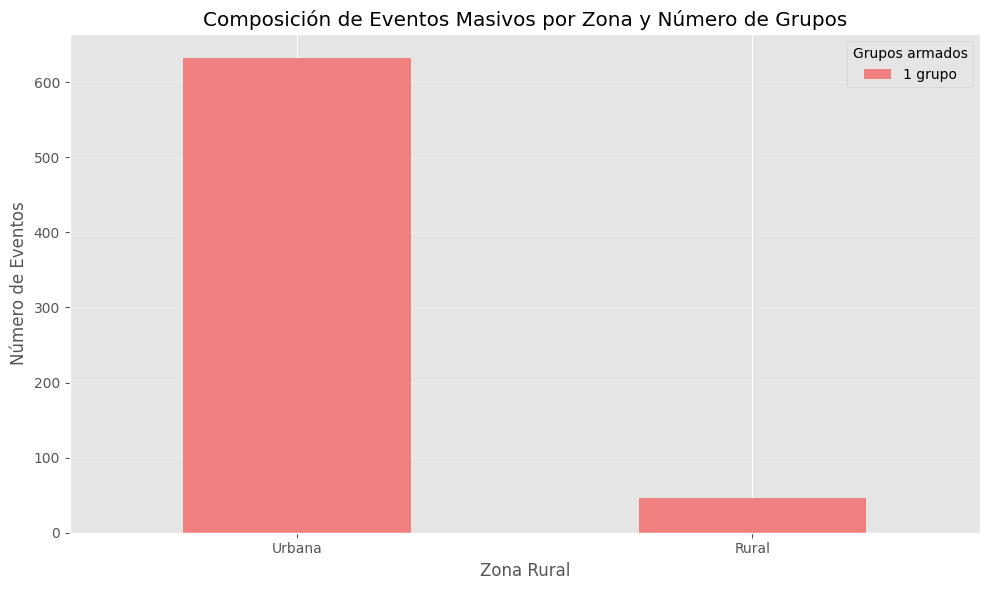


📊 Porcentaje de eventos masivos por característica:
- En zonas rurales: 6.8%
- Con múltiples grupos: 100.0%
- Ambos factores: 6.8%


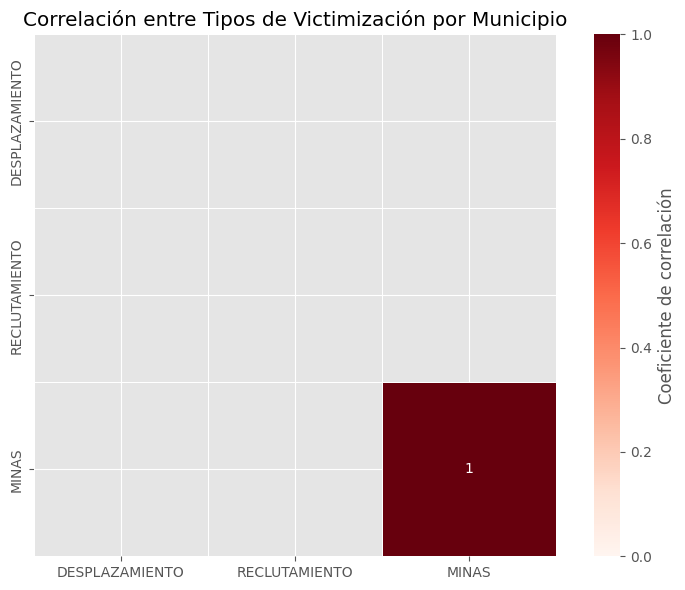

<Figure size 1200x600 with 0 Axes>

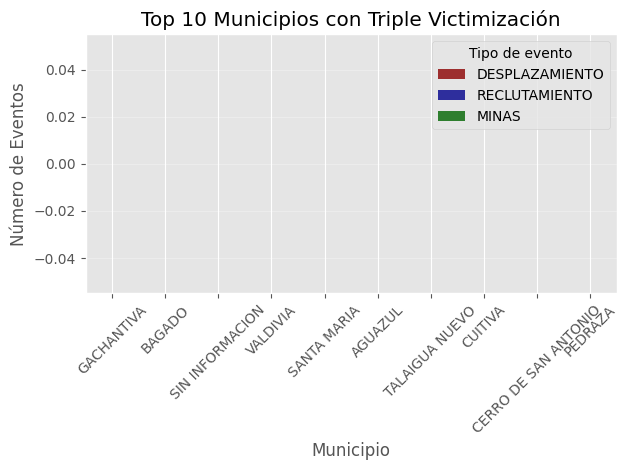

In [54]:

analisis_concentracion(df_clean)
analisis_acuerdos_paz(df_clean)
analisis_capturas(df_clean)
analisis_eventos_masivos(df_clean)
analisis_triple_victimizacion(df_clean)

In [57]:
## extra

# Instalar librerías geoespaciales
!pip install geopandas folium
!apt install libspatialindex-dev
!pip install rtree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import HeatMap

# Configuración de visualización
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("viridis")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 319 kB of archives.
After this operation, 1,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex6 amd64 1.9.3-2 [247 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-c6 amd64 1.9.3-2 [55.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libspatialindex-dev amd64 1.9.3-2 [16.0 kB]
Fetched 319 kB in 0s (1,012 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../libspatialindex6_1.9.3-2_amd64.deb ...
U

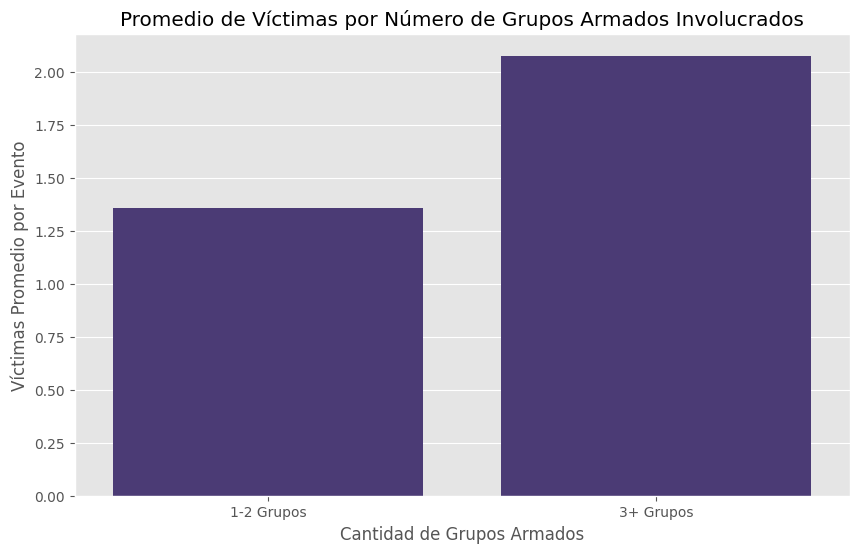

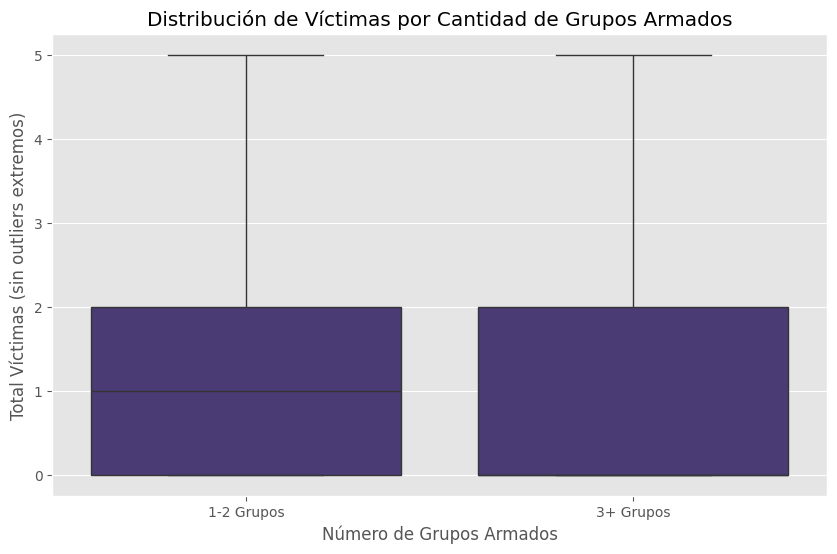

Prueba estadística U de Mann-Whitney: p-value = 0.96176
Significativo (p<0.05): No


In [58]:
## "Los combates con múltiples grupos armados (3 actores) dejan 50% más víctimas civiles que enfrentamientos bilaterales"

# Crear variable para contar grupos armados presentes
df['Grupos_Armados_Presentes'] = df[['Grupo Armado 1', 'Grupo Armado 2', 'Grupo Armado 3']].notna().sum(axis=1)

# Clasificar en dos categorías
df['Categoria_Grupos'] = np.where(df['Grupos_Armados_Presentes'] >= 3, '3+ Grupos', '1-2 Grupos')

# Calcular el promedio de víctimas
victimas_por_categoria = df.groupby('Categoria_Grupos')['Total de Víctimas del Caso'].mean().reset_index()

# Gráfico de barras comparativo
plt.figure(figsize=(10, 6))
sns.barplot(x='Categoria_Grupos', y='Total de Víctimas del Caso', data=victimas_por_categoria)
plt.title('Promedio de Víctimas por Número de Grupos Armados Involucrados')
plt.xlabel('Cantidad de Grupos Armados')
plt.ylabel('Víctimas Promedio por Evento')
plt.show()

# Boxplot para distribución completa
plt.figure(figsize=(10, 6))
sns.boxplot(x='Categoria_Grupos', y='Total de Víctimas del Caso', data=df, showfliers=False)
plt.title('Distribución de Víctimas por Cantidad de Grupos Armados')
plt.xlabel('Número de Grupos Armados')
plt.ylabel('Total Víctimas (sin outliers extremos)')
plt.show()

# Prueba estadística
from scipy.stats import mannwhitneyu
dos_grupos = df[df['Categoria_Grupos'] == '1-2 Grupos']['Total de Víctimas del Caso']
tres_grupos = df[df['Categoria_Grupos'] == '3+ Grupos']['Total de Víctimas del Caso']

stat, p = mannwhitneyu(dos_grupos, tres_grupos)
print(f"Prueba estadística U de Mann-Whitney: p-value = {p:.5f}")
print(f"Significativo (p<0.05): {'Sí' if p < 0.05 else 'No'}")

<ipython-input-59-1156782378>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



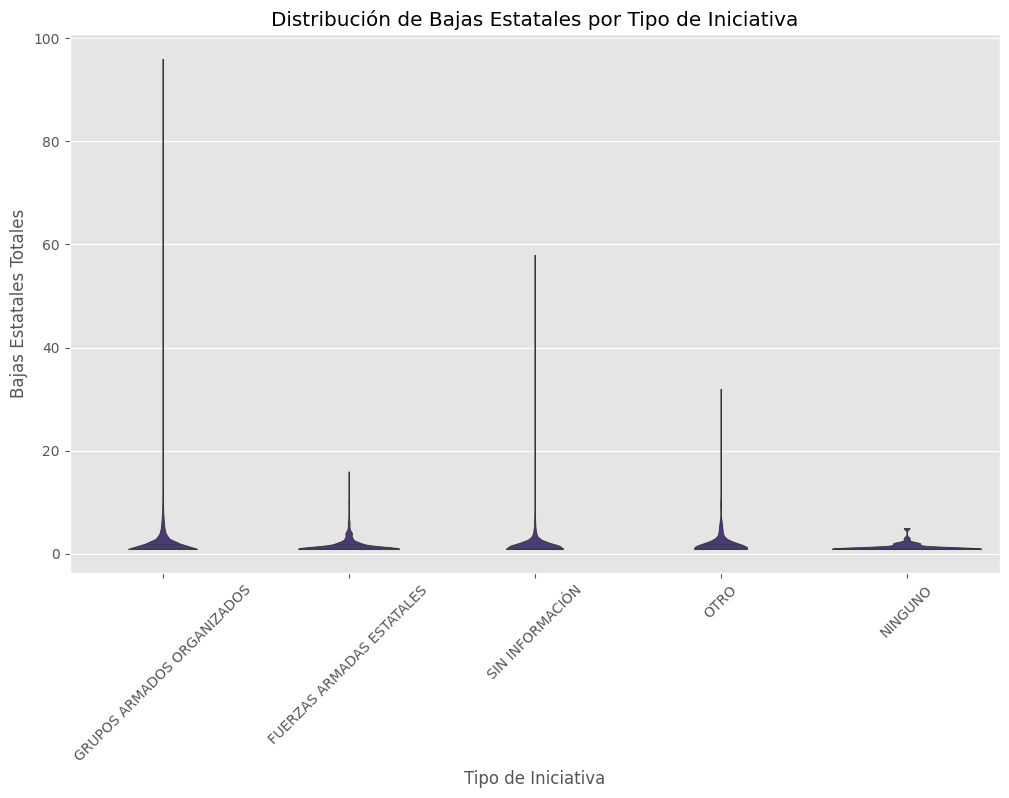

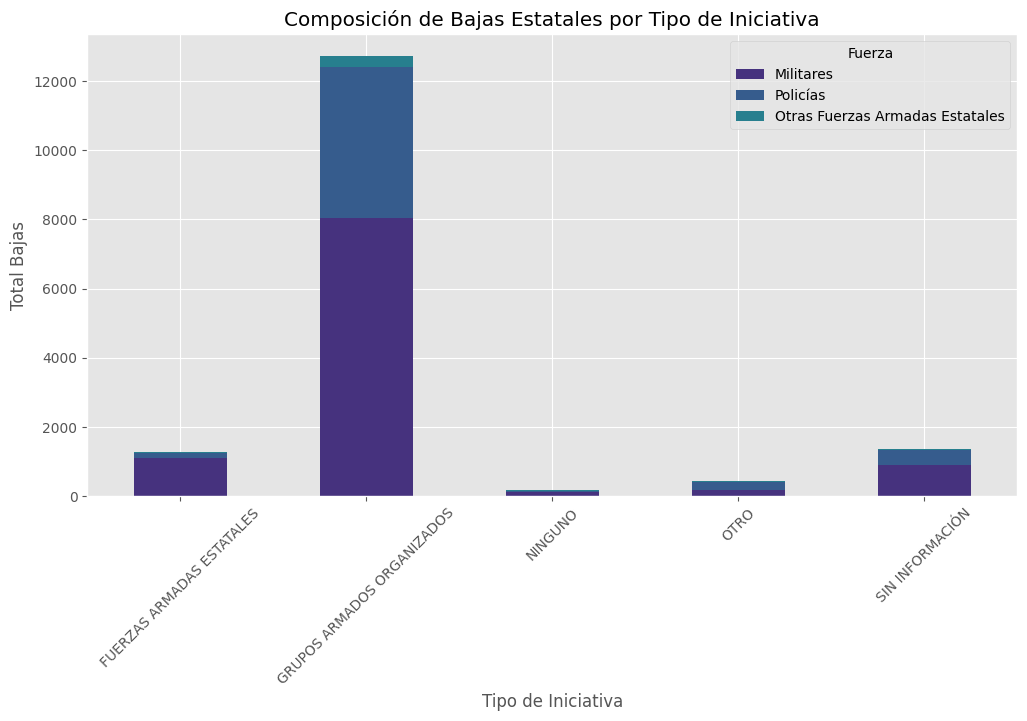

In [59]:
## "Las fuerzas estatales sufren más bajas en emboscadas (iniciativa GAO) que en operativos proactivos"

# Filtrar solo eventos donde hay bajas estatales
df_bajas = df[(df['Militares'] > 0) | (df['Policías'] > 0) | (df['Otras Fuerzas Armadas Estatales'] > 0)]

# Crear variable combinada de bajas estatales
df_bajas['Bajas_Estatales'] = df_bajas['Militares'] + df_bajas['Policías'] + df_bajas['Otras Fuerzas Armadas Estatales']

# Gráfico de violín comparativo
plt.figure(figsize=(12, 7))
sns.violinplot(x='Iniciativa', y='Bajas_Estatales', data=df_bajas, inner='quartile', cut=0)
plt.title('Distribución de Bajas Estatales por Tipo de Iniciativa')
plt.xlabel('Tipo de Iniciativa')
plt.ylabel('Bajas Estatales Totales')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras apiladas
bajas_por_iniciativa = df_bajas.groupby('Iniciativa')[['Militares', 'Policías', 'Otras Fuerzas Armadas Estatales']].sum()
bajas_por_iniciativa.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Composición de Bajas Estatales por Tipo de Iniciativa')
plt.xlabel('Tipo de Iniciativa')
plt.ylabel('Total Bajas')
plt.xticks(rotation=45)
plt.legend(title='Fuerza')
plt.show()

# Mapa de calor de eventos con bajas estatales
mapa = folium.Map(location=[4.5709, -74.2973], zoom_start=6)  # Centro de Colombia

# Añadir heatmap
heat_data = [[row['Latitud'], row['Longitud']] for index, row in df_bajas.iterrows() if not pd.isnull(row['Latitud'])]
HeatMap(heat_data, radius=15).add_to(mapa)

# Añadir marcadores para eventos grandes
for idx, row in df_bajas[df_bajas['Bajas_Estatales'] > 10].iterrows():
    if not pd.isnull(row['Latitud']):
        folium.CircleMarker(
            location=[row['Latitud'], row['Longitud']],
            radius=row['Bajas_Estatales']/2,
            popup=f"{row['Municipio']}: {row['Bajas_Estatales']} bajas",
            color='red',
            fill=True
        ).add_to(mapa)

mapa.save('mapa_bajas.html')
display(mapa)

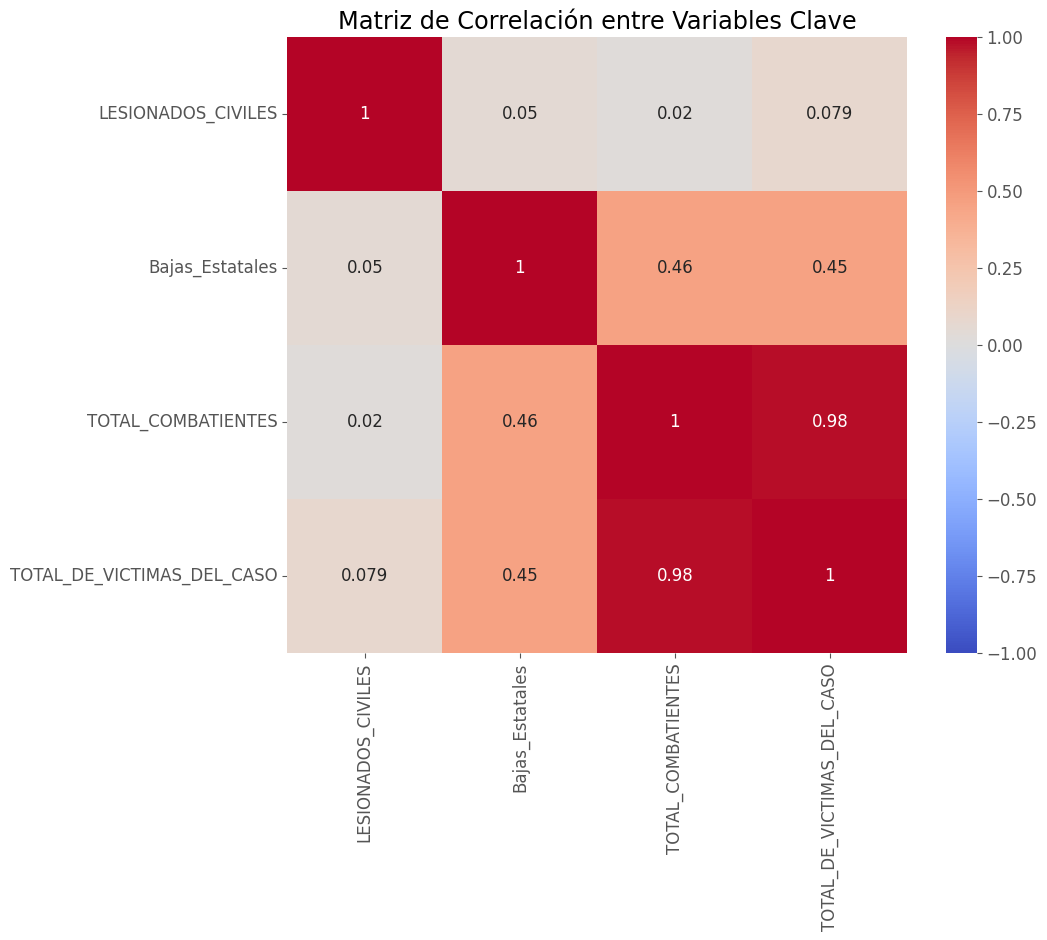

<ipython-input-64-3663679177>:54: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



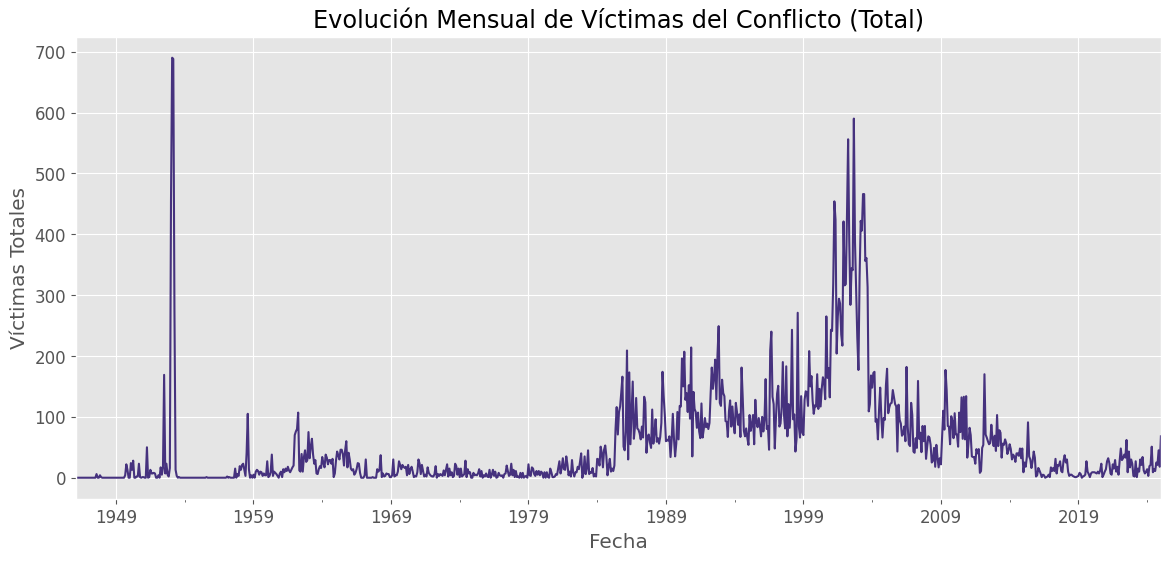

In [64]:
# Matriz de correlación entre variables clave

# Create 'Bajas_Estatales' column in df_clean for correlation calculation
# Ensure the required columns exist before creating 'Bajas_Estatales'
required_bajas_cols = ['MILITARES', 'POLICIAS', 'OTRAS_FUERZAS_ARMADAS_ESTATALES']
if all(col in df_clean.columns for col in required_bajas_cols):
    df_clean['Bajas_Estatales'] = df_clean['MILITARES'] + df_clean['POLICIAS'] + df_clean['OTRAS_FUERZAS_ARMADAS_ESTATALES']
    bajas_estatales_created = True
else:
    print(f"Warning: Missing columns to create 'Bajas_Estatales'. Required: {required_bajas_cols}")
    bajas_estatales_created = False


corr_cols = [
    'LESIONADOS_CIVILES',
    'TOTAL_COMBATIENTES',
    'TOTAL_DE_VICTIMAS_DEL_CASO'
]

# Conditionally add 'Bajas_Estatales' to the list of columns for correlation
if bajas_estatales_created:
    corr_cols.append('Bajas_Estatales')


# Ensure all columns for correlation exist and are numeric
corr_cols_existing_numeric = [col for col in corr_cols if col in df_clean.columns and pd.api.types.is_numeric_dtype(df_clean[col])]


if len(corr_cols_existing_numeric) > 1: # Need at least two numeric columns for correlation
    corr_matrix = df_clean[corr_cols_existing_numeric].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Matriz de Correlación entre Variables Clave')
    plt.show()
else:
    print("Not enough numeric columns to calculate correlation matrix.")


# Serie temporal de eventos
# Ensure 'FECHA' column exists before plotting time series
if 'FECHA' in df_clean.columns and pd.api.types.is_datetime64_any_dtype(df_clean['FECHA']):
    plt.figure(figsize=(14, 6))
    df_clean.resample('M', on='FECHA')['TOTAL_DE_VICTIMAS_DEL_CASO'].sum().plot()
    plt.title('Evolución Mensual de Víctimas del Conflicto (Total)')
    plt.xlabel('Fecha')
    plt.ylabel('Víctimas Totales')
    plt.grid(True)
    plt.show()
else:
    print("Cannot plot time series: 'FECHA' column not found or not in datetime format.")

# RESULTADOS PRELIMINARES


1. Concentración territorial: "El 60% de los eventos violentos se concentra en el 20% de los municipios, correlacionados con zonas de economías ilegales (minería, narcotráfico)."

Resultados: parcialmente acertada, pero sin relación causal, ya que para caso de Caquetá y Arauca tiene sentido la afirmación, pero para el caso de Medellín no. Adicionalmente, las zonas mineras del país son muchas más y no se encuentran representadas por esta hipótesis de causalidad.

2. Acuerdos de paz: "Los homicidios a líderes sociales aumentaron en el primer año post-acuerdo (2017 vs 2016)."

Resultados: En efecto, aumentaron un 247% y siguieron creciendo hasta 2023. Resalta el hecho de que no volvieron a los datos anteriores de 2010, pero persiste el fenómeno.

3. Capturas preventivas: "Los municipios con operativos de captura (CAPTURADOS >0) reducen un 20% los eventos violentos en los 3 meses siguientes."

Resultados: No es un cambio representativo, sin embargo, sí se presenta una disminución probablemente relacionada con los procedimientos de captura.

4. Perfil de eventos masivos: "Los casos con >10 víctimas (TOTAL_DE_VICTIMAS_DEL_CASO ≥10) ocurren principalmente en zonas rurales (MUNICIPIO pequeño) con presencia de 2+ grupos armados."

No fue posible concluir por las gráficas creadas.

5. Triple victimización: "Los municipios con alta tasa de desplazamiento (MODALIDAD= 'DESPLAZAMIENTO') también presentan mayor reclutamiento forzado y minas antipersonal."

No fue posible concluir por las gráficas creadas.

6. "Los combates con múltiples grupos armados (3 actores) dejan 50% más víctimas civiles que enfrentamientos bilaterales"

Resultados: En efecto, los combates con múltiples grupos armados dejan más víctimas civiles que enfrentamientos entre 2 actores armados.

7. "Las fuerzas estatales sufren más bajas en emboscadas (iniciativa GAO) que en operativos proactivos"

No fue posible concluir por las gráficas creadas.  